# Design MERFISH for Brain MS immune cells

by Pu Zheng

2023.6.28

In [31]:
import os, sys, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import torch
print(os.getpid())
sys.path.append(r'C:\Softwares\Github\MerScope01')

18164


## Master folder
folder storing all the libraries

In [2]:
library_master_folder = r'\\wi-bigdata.wi.mit.edu\solexa_weissman\puzheng\MERFISH_Probes'
print(f"- FISH probe libraries stored in folder: {library_master_folder}")


- FISH probe libraries stored in folder: \\wi-bigdata.wi.mit.edu\solexa_weissman\puzheng\MERFISH_Probes


## References:

GRCm39:
https://ftp.ensembl.org/pub/release-109/fasta/mus_musculus/ 

In [3]:
reference_folder = r'\\wi-bigdata.wi.mit.edu\solexa_weissman\puzheng\References'
print(os.listdir(os.path.join(reference_folder, 'GRCm39', 'Transcriptome')))

['.DS_Store', 'Mus_musculus.GRCm39.109.gff3', 'Mus_musculus.GRCm39.cdna.all.fa', 'Mus_musculus.GRCm39.ncrna.fa', 'rtRNA_15.table', 'transcriptome_17.table']


# Define design parameters

## Folders

In [4]:
# Define the output files
library_folder = os.path.join(library_master_folder, 'Brain_MS_immune')
print(f"- library will be saved in: {library_folder}")
if not os.path.exists(library_folder):
    os.makedirs(library_folder)
    print(f"-- create library_folder: {library_folder}")
probe_output_file = os.path.join(library_folder, 'designed_probes.csv')
print(f"-- library savefile: {probe_output_file}")
probe_output_idt_file = os.path.join(library_folder, 'designed_probes_idt_oPool.xlsx')
print(f"-- library IDT format savefile: {probe_output_idt_file}")

- library will be saved in: \\wi-bigdata.wi.mit.edu\solexa_weissman\puzheng\MERFISH_Probes\Brain_MS_immune
-- library savefile: \\wi-bigdata.wi.mit.edu\solexa_weissman\puzheng\MERFISH_Probes\Brain_MS_immune\designed_probes.csv
-- library IDT format savefile: \\wi-bigdata.wi.mit.edu\solexa_weissman\puzheng\MERFISH_Probes\Brain_MS_immune\designed_probes_idt_oPool.xlsx


## Input files:

In [5]:
library_folder

'\\\\wi-bigdata.wi.mit.edu\\solexa_weissman\\puzheng\\MERFISH_Probes\\Brain_MS_immune'

In [6]:
# The output codebook filename
codebook_file = os.path.join(library_folder, 'codebook.csv')
# gene mean expression
target_gene_mean_exp_filename = os.path.join(library_folder, 'selected_gene_mean_exp.csv')
# readout file
readout_savefile = os.path.join(library_folder, 'readouts.csv')

You could also download an example data from:

http://zhuang.harvard.edu/merfish.html

In [7]:
# Define transcriptome reference
mRNA_fasta_file = os.path.join(reference_folder, 'GRCm39', 'Transcriptome', 
                                      r'Mus_musculus.GRCm39.cdna.all.fa')
ncRNA_fasta_file = os.path.join(reference_folder, 'GRCm39', 'Transcriptome',
                                      r'Mus_musculus.GRCm39.ncrna.fa')
gff3_file = os.path.join(reference_folder, 'GRCm39', 'Transcriptome',
                                      r'Mus_musculus.GRCm39.109.gff3')

# Define readout sequences
readout_fasta_file = os.path.join(reference_folder, 'Readouts',
                                  r'MERFISH_readouts.fasta')
if os.path.isfile(readout_fasta_file):
    print("readout_fasta_file exists")
else:
    print("readout_fasta_file doesn't exist")
    
# Define primer sequences
forward_primer_file = os.path.join(reference_folder, 'Primers',
                                   r'forward_primers_keep.fasta')
reverse_primer_file = os.path.join(reference_folder, 'Primers',
                                   r'reverse_primers_keep.fasta')
                                   #r'T7_reverse_primers.fasta')
selected_primers_file = os.path.join(library_folder, 'selected_primers.csv')

print(os.path.isfile(forward_primer_file), os.path.isfile(reverse_primer_file))
# Define FPKM reference (Not necessary for smFISH)
fpkm_tracking_file = os.path.join(library_folder, r'isoforms.fpkm_tracking')

readout_fasta_file exists
True True


## Packages

for MERFISH probe design, please refer to package: 
https://github.com/zhengpuas47/MERFISH_probe_design

In [8]:
import numpy as np
import pandas as pd

from IPython.display import display

import MERFISH_probe_design.IO.file_io as fio
import MERFISH_probe_design.probe_design.probe_dict as p_d
import MERFISH_probe_design.probe_design.OTTable_dict as ot
import MERFISH_probe_design.probe_design.readout_sequences as rs
import MERFISH_probe_design.probe_design.probe_selection as ps
import MERFISH_probe_design.probe_design.quality_check as qc
from MERFISH_probe_design.probe_design import filters
from MERFISH_probe_design.probe_design import plot
from MERFISH_probe_design.probe_design import primer_design

# Design targeting sequences

## Load required parameters

In [9]:
%%time
# Load the transcriptome as a pandas data frame
cdna = fio.load_transcriptome(mRNA_fasta_file, None)
ncrna = fio.load_transcriptome(ncRNA_fasta_file, None)
transcriptome = pd.concat([cdna, ncrna])
#transcriptome = fio.load_transcriptome(mRNA_fasta_file, fpkm_tracking_file) #MERFISH version

# Make sure that the transcriptome data frame has the standard column names.
# The standard columns are: transcript_id, sequence, gene_id, gene_short_name and FPKM.
# Also remove the non-standard columns for clarity.
transcriptome = qc.check_and_standardize_transcriptome(transcriptome, remove_non_standard_columns=True)

# This FPKM data is not for our cell type of interest. So set the FPKMs to be all 1.
transcriptome['FPKM'] = 1

Loaded 116912 transcripts.
116912
Loaded 29245 transcripts.
29245
CPU times: total: 4.73 s
Wall time: 7.7 s


# Load gene-selection

In [10]:
# save
print(f"Loading mean_exp for target genes: {target_gene_mean_exp_filename}")
target_gene_mean_exp_df = pd.read_csv(target_gene_mean_exp_filename).set_index("gene_symbols")

Loading mean_exp for target genes: \\wi-bigdata.wi.mit.edu\solexa_weissman\puzheng\MERFISH_Probes\Brain_MS_immune\selected_gene_mean_exp.csv


In [11]:
# Modify transcriptome to add information:
transcriptome.loc[transcriptome['gene_id']=='ENSMUSG00000037548.16', 'gene_short_name'] = 'H2-DMb2'
transcriptome.loc[transcriptome['gene_id']=='ENSMUSG00000037649.11', 'gene_short_name'] = 'H2-DMa'
transcriptome.loc[transcriptome['gene_id']=='ENSMUSG00000112023.2', 'gene_short_name'] = 'Lilr4b'
transcriptome.loc[transcriptome['gene_id']=='ENSMUSG00000079547.5', 'gene_short_name'] = 'H2-DMb1'
# replace gene-list:
replace_dict = {'Tcrg-C1':'Trgc1', 'Tcrg-C2':'Trgc2', 'Tcrg-C4':'Trgc4', 'Sept1':'Septin1', 'H2afy':'Macroh2a2','Qk':'Qki'}
target_gene_mean_exp_df.rename(index=replace_dict, inplace=True)

# check if all exists
for _gene in list(target_gene_mean_exp_df.index):
    # Let's have a look at the transcripts of the FLNA gene
    _transcripts = transcriptome[transcriptome['gene_short_name'] == _gene].sort_values('FPKM', ascending=False)
    if len(_transcripts) == 0:
        print(_gene, len(_transcripts))

## Load codebook

In [12]:
# Load the codebook
cb_version, cb_name, bit_names, barcode_table = fio.load_merlin_codebook(codebook_file)
barcode_table.replace({'name':replace_dict}, inplace=True)
gene_ids = list(target_gene_mean_exp_df.index)
transcript_ids = set(barcode_table['id'][barcode_table['id'] != '']) # Get the non-blank transcript ids
barcode_table # Let's have a look at the barcode table

,name,id,barcode_str
0,Mmp25,,0000000010000010011000
1,Ms4a1,,0010000010000000010001
2,Il17f,,1000000001001001000000
3,Il22,,1110100000000000000000
4,Tanc2,,0001001000001000000001
...,...,...,...
309,Blank-16,,0000010010010000001000
310,Blank-17,,1101000000000000000001
311,Blank-18,,1100000011000000000000
312,Blank-19,,0000000100011000100000


In [13]:
# Initialize the probe dictionary which is the carrier of the probes throught the design process.
probe_dict = p_d.init_probe_dict(gene_ids, transcriptome, 'gene_short_name', K=30)
if len(transcript_ids) == len(gene_ids):
    # Select the transcripts that we want to target
    # The target transcripts are already defined in the codebook
    p_d.select_transcripts_by_ids(probe_dict, transcript_ids)
# Init
p_d.print_probe_dict(probe_dict)

Found 1556 transcripts for 294 target genes.
Gene	Transcript	N_probes
Trbc1
	ENSMUST00000192856.6	708
	ENSMUST00000103291.2	483
Trbc2
	ENSMUST00000103299.3	663
Trac
	ENSMUST00000198398.5	906
	ENSMUST00000103740.2	384
Trgc1
	ENSMUST00000103558.3	895
Trgc2
	ENSMUST00000103561.3	885
Trgc4
	ENSMUST00000179181.3	956
Igkc
	ENSMUST00000103410.3	503
Ighm
	ENSMUST00000177715.8	1669
	ENSMUST00000103426.3	1464
Iglc3
	ENSMUST00000200235.2	423
Iglc2
	ENSMUST00000198182.2	429
	ENSMUST00000103749.3	577
Csf1r
	ENSMUST00000237873.2	436
	ENSMUST00000025523.13	3841
	ENSMUST00000235447.2	747
	ENSMUST00000237706.2	387
	ENSMUST00000237485.2	2006
	ENSMUST00000115268.4	4672
Tigit
	ENSMUST00000096065.6	890
Lyz1
	ENSMUST00000092162.7	1234
Tbc1d4
	ENSMUST00000161991.8	6454
	ENSMUST00000161304.2	3794
	ENSMUST00000159951.8	5014
	ENSMUST00000162617.8	4733
	ENSMUST00000160297.8	3074
	ENSMUST00000159484.8	2711
	ENSMUST00000159668.8	2684
	ENSMUST00000159664.8	1020
	ENSMUST00000100340.4	3220
	ENSMUST00000160473.2	645
C

In [14]:
len(probe_dict)

294

# First round design

To determine number of probes

### Calculate and filter by probe GC

c:\softwares\github\merfish_probe_design\MERFISH_probe_design\probe_design\filters.py:35: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  probe_dict[gk][tk][column_key_write] = pd.Series(gcs, index=probe_dict[gk][tk].index)


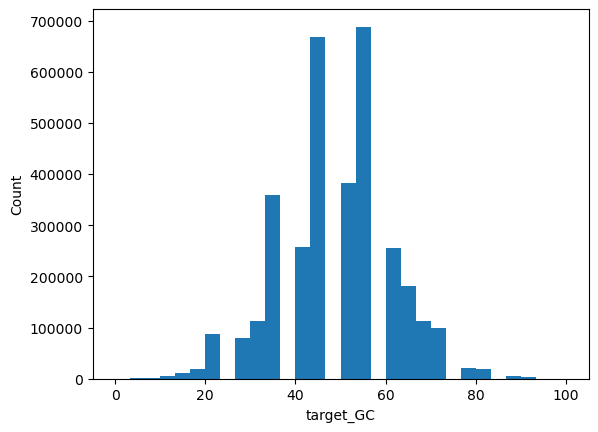

In [15]:
# Calculate and plot the GC contents of the target regions
filters.calc_gc_for_probe_dict(probe_dict, column_key_seq='target_sequence', column_key_write='target_GC')
plot.plot_hist(probe_dict, column_key='target_GC')

Trbc1
	ENSMUST00000192856.6: 513 / 708 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000103291.2: 454 / 483 probes passed the filter 40 < target_GC <  70.
Trbc2
	ENSMUST00000103299.3: 555 / 663 probes passed the filter 40 < target_GC <  70.
Trac
	ENSMUST00000198398.5: 660 / 906 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000103740.2: 325 / 384 probes passed the filter 40 < target_GC <  70.
Trgc1
	ENSMUST00000103558.3: 530 / 895 probes passed the filter 40 < target_GC <  70.
Trgc2
	ENSMUST00000103561.3: 522 / 885 probes passed the filter 40 < target_GC <  70.
Trgc4
	ENSMUST00000179181.3: 513 / 956 probes passed the filter 40 < target_GC <  70.
Igkc
	ENSMUST00000103410.3: 414 / 503 probes passed the filter 40 < target_GC <  70.
Ighm
	ENSMUST00000177715.8: 1397 / 1669 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000103426.3: 1239 / 1464 probes passed the filter 40 < target_GC <  70.
Iglc3
	ENSMUST00000200235.2: 351 / 423 probes passed the filter 40 < ta

c:\softwares\github\merfish_probe_design\MERFISH_probe_design\probe_design\filters.py:17: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  new_df = probe_dict[gk][tk][probe_dict[gk][tk][column_key].between(


	ENSMUST00000218369.2: 1947 / 2488 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000167340.2: 623 / 801 probes passed the filter 40 < target_GC <  70.
Tmem176b
	ENSMUST00000166247.8: 1277 / 1385 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000164733.4: 1489 / 1619 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000101429.11: 1117 / 1209 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000203355.3: 1029 / 1173 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000204073.3: 929 / 957 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000204783.3: 568 / 585 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000205159.3: 621 / 628 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000203229.3: 728 / 737 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000205147.3: 693 / 713 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000203265.3: 697 / 704 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000203501.

	ENSMUST00000159497.2: 673 / 1129 probes passed the filter 40 < target_GC <  70.
Klrd1
	ENSMUST00000112063.9: 290 / 866 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000119520.8: 276 / 890 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000159804.2: 148 / 509 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000203965.2: 177 / 478 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000159077.2: 165 / 551 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000032268.14: 274 / 557 probes passed the filter 40 < target_GC <  70.
Havcr2
	ENSMUST00000020668.15: 1814 / 2692 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000109229.2: 1666 / 2502 probes passed the filter 40 < target_GC <  70.
Klrk1
	ENSMUST00000168919.8: 1610 / 3168 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000032252.8: 700 / 1241 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000095412.10: 624 / 990 probes passed the filter 40 < target_GC <  70.
	ENSMUST00

	ENSMUST00000004850.8: 2416 / 3095 probes passed the filter 40 < target_GC <  70.
Il12a
	ENSMUST00000029345.12: 937 / 1274 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000107816.5: 948 / 1311 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000195408.6: 687 / 757 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000191910.2: 548 / 610 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000192812.5: 887 / 1267 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000195517.3: 887 / 1269 probes passed the filter 40 < target_GC <  70.
Aprt
	ENSMUST00000213062.2: 481 / 531 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000006764.9: 739 / 820 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000212093.2: 568 / 694 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000213030.2: 562 / 631 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000213029.2: 800 / 900 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000211823.2:

	ENSMUST00000113064.8: 1921 / 2296 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000129131.8: 1321 / 1479 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000201690.2: 289 / 357 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000201335.2: 1552 / 1951 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000141238.2: 529 / 599 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000156479.3: 2587 / 3386 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000135870.2: 212 / 290 probes passed the filter 40 < target_GC <  70.
C5ar1
	ENSMUST00000050770.6: 1744 / 2452 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000168818.2: 1808 / 2511 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000209442.2: 552 / 645 probes passed the filter 40 < target_GC <  70.
Ldha
	ENSMUST00000147535.8: 752 / 883 probes passed the filter 40 < target_GC <  70.
	ENSMUST00000048209.16: 1251 / 1559 probes passed the filter 40 < target_GC <  70.
	ENSMUST000002

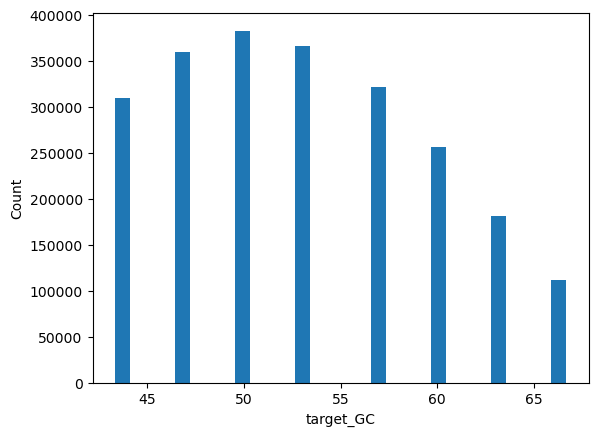

In [16]:
# Filter GC cotent and plot the GC content after filtering
filters.filter_probe_dict_by_metric(probe_dict, 'target_GC', lower_bound=40, upper_bound=70)
plot.plot_hist(probe_dict, column_key='target_GC', bins=30)

### Calculate and filter by probe Tm

c:\softwares\github\merfish_probe_design\MERFISH_probe_design\probe_design\filters.py:55: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  probe_dict[gk][tk][column_key_write] = pd.Series(tms, index=probe_dict[gk][tk].index)


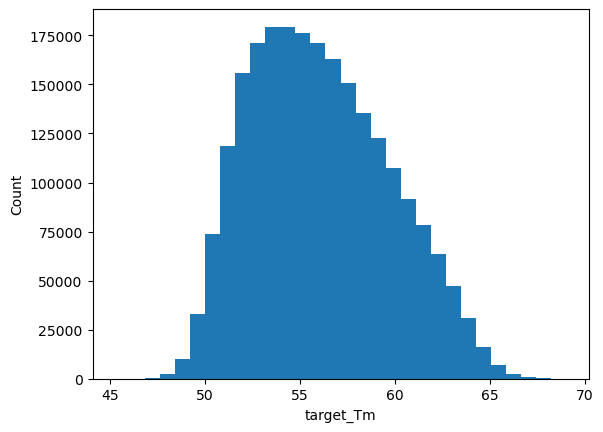

In [17]:
# Calculate and plot the melting-temperatures (Tm)
filters.calc_tm_for_probe_dict(probe_dict, Na_conc=390, fmd_percentile=30, probe_conc=5,
                              column_key_seq='target_sequence', column_key_write='target_Tm')
plot.plot_hist(probe_dict, column_key='target_Tm')

Trbc1
	ENSMUST00000192856.6: 504 / 513 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000103291.2: 453 / 454 probes passed the filter 50 < target_Tm <  65.
Trbc2
	ENSMUST00000103299.3: 548 / 555 probes passed the filter 50 < target_Tm <  65.
Trac
	ENSMUST00000198398.5: 653 / 660 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000103740.2: 321 / 325 probes passed the filter 50 < target_Tm <  65.
Trgc1
	ENSMUST00000103558.3: 503 / 530 probes passed the filter 50 < target_Tm <  65.
Trgc2
	ENSMUST00000103561.3: 501 / 522 probes passed the filter 50 < target_Tm <  65.
Trgc4
	ENSMUST00000179181.3: 497 / 513 probes passed the filter 50 < target_Tm <  65.
Igkc
	ENSMUST00000103410.3: 396 / 414 probes passed the filter 50 < target_Tm <  65.
Ighm
	ENSMUST00000177715.8: 1380 / 1397 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000103426.3: 1224 / 1239 probes passed the filter 50 < target_Tm <  65.
Iglc3
	ENSMUST00000200235.2: 351 / 351 probes passed the filter 50 < ta

c:\softwares\github\merfish_probe_design\MERFISH_probe_design\probe_design\filters.py:17: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  new_df = probe_dict[gk][tk][probe_dict[gk][tk][column_key].between(


	ENSMUST00000203265.3: 691 / 697 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000203501.2: 717 / 722 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000203618.2: 499 / 501 probes passed the filter 50 < target_Tm <  65.
Tmem123
	ENSMUST00000052865.16: 1162 / 1187 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000136904.8: 266 / 267 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000154371.2: 1250 / 1271 probes passed the filter 50 < target_Tm <  65.
Birc2
	ENSMUST00000190341.7: 1753 / 1859 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000191248.2: 231 / 240 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000189935.2: 676 / 681 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000074246.7: 1674 / 1775 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000054878.6: 176 / 178 probes passed the filter 50 < target_Tm <  65.
Mef2a
	ENSMUST00000156690.8: 2459 / 2511 probes passed the filter 50 < target_Tm <  65.
	ENSMUST0

	ENSMUST00000160159.3: 2142 / 2257 probes passed the filter 50 < target_Tm <  65.
Svil
	ENSMUST00000126977.8: 6058 / 6209 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000131210.8: 1017 / 1050 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000138258.8: 942 / 969 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000143254.8: 4999 / 5137 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000153016.8: 257 / 259 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000140448.8: 5994 / 6141 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000148564.2: 725 / 740 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000210707.2: 5905 / 6053 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000127297.8: 5262 / 5400 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000131609.8: 5412 / 5540 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000125512.8: 2926 / 2999 probes passed the filter 50 < target_Tm <  65.
	ENSMUST000001397

	ENSMUST00000137139.2: 1352 / 1369 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000133911.2: 447 / 450 probes passed the filter 50 < target_Tm <  65.
Nos2
	ENSMUST00000018610.7: 3589 / 3656 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000208783.2: 529 / 535 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000214397.3: 2995 / 3052 probes passed the filter 50 < target_Tm <  65.
Ctsl
	ENSMUST00000222517.2: 3546 / 3676 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000222971.2: 380 / 386 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000222462.2: 586 / 594 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000223494.2: 527 / 538 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000220737.2: 644 / 654 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000220617.2: 223 / 223 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000021933.8: 1227 / 1250 probes passed the filter 50 < target_Tm <  65.
Batf3
	ENSMUST000001

	ENSMUST00000054462.11: 3218 / 3273 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000192099.2: 247 / 250 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000192531.6: 2702 / 2747 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000193823.2: 2762 / 2809 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000195854.2: 571 / 582 probes passed the filter 50 < target_Tm <  65.
Hdc
	ENSMUST00000028838.5: 2049 / 2069 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000124396.2: 438 / 444 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000138752.2: 3222 / 3341 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000132382.2: 394 / 401 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000148591.2: 299 / 299 probes passed the filter 50 < target_Tm <  65.
Ptprc
	ENSMUST00000112036.5: 2219 / 2303 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000182283.8: 2257 / 2327 probes passed the filter 50 < target_Tm <  65.
	ENSMUST0000018

	ENSMUST00000239431.2: 2047 / 2075 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000049460.12: 2040 / 2068 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000129997.2: 759 / 763 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000135517.2: 703 / 708 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000148580.2: 407 / 409 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000176953.2: 676 / 684 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000138451.2: 591 / 601 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000123500.3: 810 / 820 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000125819.9: 721 / 735 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000127530.3: 434 / 442 probes passed the filter 50 < target_Tm <  65.
	ENSMUST00000177428.2: 963 / 1001 probes passed the filter 50 < target_Tm <  65.
Ctsz
	ENSMUST00000016400.9: 1180 / 1194 probes passed the filter 50 < target_Tm <  65.
Il13
	ENSMUST00000020650.2:

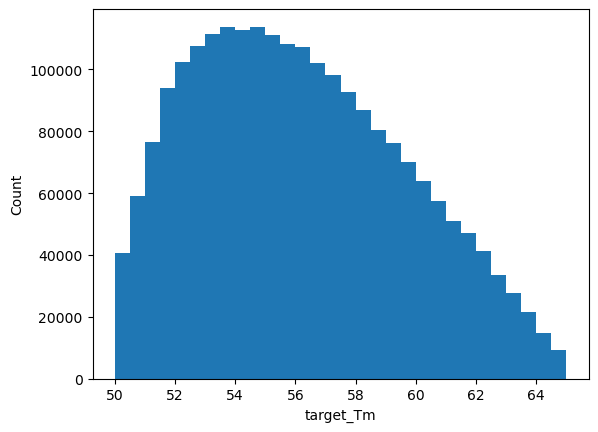

In [18]:
# Filter by Tm
# NOTE: here we used a higher upper bound for GC content and Tm than JM's original
# cutoffs. It was shown that higher Tm gives better signal-to-noise ratios in SM-FISH
filters.filter_probe_dict_by_metric(probe_dict, 'target_Tm', lower_bound=50, upper_bound=65)
plot.plot_hist(probe_dict, column_key='target_Tm')

### Calculate off-targets

In [19]:
# Initialize the off-target counting tables
overwrite_ottable = False
# OTTable for rRNA/tRNAs
if 'ottable_rtRNAs' not in locals() or overwrite_ottable:
    ncRNAs =  fio.load_fasta_into_df(ncRNA_fasta_file)
    ottable_rtRNAs = ot.get_OTTable_for_rtRNAs(ncRNAs, 15)

Found 378 rRNAs/tRNAs from 29245 non-coding RNAs.


In [20]:
# OTTables for the genes we target
if 'gene_ottable_dict' not in locals() or overwrite_ottable:
    #gene_ottable_dict = ot.get_gene_OTTables(transcriptome, sel_isoform_names, 'transcript_id', 17)
    gene_ottable_dict = ot.get_gene_OTTables(transcriptome, gene_ids, 'gene_short_name', 17)

Generate OTTable for gene Mmp25.
Construct a OTTable using 3/3 transcripts with FPKM > 0.
Generate OTTable for gene Ms4a1.
Construct a OTTable using 3/3 transcripts with FPKM > 0.
Generate OTTable for gene Il17f.
Construct a OTTable using 4/4 transcripts with FPKM > 0.
Generate OTTable for gene Il22.
Construct a OTTable using 1/1 transcripts with FPKM > 0.
Generate OTTable for gene Tanc2.
Construct a OTTable using 8/8 transcripts with FPKM > 0.
Generate OTTable for gene Olfml3.
Construct a OTTable using 4/4 transcripts with FPKM > 0.
Generate OTTable for gene Eno3.
Construct a OTTable using 8/8 transcripts with FPKM > 0.
Generate OTTable for gene Cxcr2.
Construct a OTTable using 2/2 transcripts with FPKM > 0.
Generate OTTable for gene Ctsl.
Construct a OTTable using 7/7 transcripts with FPKM > 0.
Generate OTTable for gene Mertk.
Construct a OTTable using 2/2 transcripts with FPKM > 0.
Generate OTTable for gene Bcl11a.
Construct a OTTable using 6/6 transcripts with FPKM > 0.
Generate OT

Construct a OTTable using 12/12 transcripts with FPKM > 0.
Generate OTTable for gene Atp1b1.
Construct a OTTable using 4/4 transcripts with FPKM > 0.
Generate OTTable for gene Ace.
Construct a OTTable using 4/4 transcripts with FPKM > 0.
Generate OTTable for gene Ear2.
Construct a OTTable using 1/1 transcripts with FPKM > 0.
Generate OTTable for gene Ly6g.
Construct a OTTable using 2/2 transcripts with FPKM > 0.
Generate OTTable for gene Naca.
Construct a OTTable using 2/2 transcripts with FPKM > 0.
Generate OTTable for gene Ptprcap.
Construct a OTTable using 2/2 transcripts with FPKM > 0.
Generate OTTable for gene Ly6d.
Construct a OTTable using 1/1 transcripts with FPKM > 0.
Generate OTTable for gene Csf3r.
Construct a OTTable using 4/4 transcripts with FPKM > 0.
Generate OTTable for gene Ighm.
Construct a OTTable using 2/2 transcripts with FPKM > 0.
Generate OTTable for gene Itgae.
Construct a OTTable using 2/2 transcripts with FPKM > 0.
Generate OTTable for gene Slc49a4.
Construct 

Generate OTTable for gene Fcrls.
Construct a OTTable using 2/2 transcripts with FPKM > 0.
Generate OTTable for gene Gata3.
Construct a OTTable using 6/6 transcripts with FPKM > 0.
Generate OTTable for gene Il2ra.
Construct a OTTable using 3/3 transcripts with FPKM > 0.
Generate OTTable for gene Foxp1.
Construct a OTTable using 31/31 transcripts with FPKM > 0.
Generate OTTable for gene Hdc.
Construct a OTTable using 5/5 transcripts with FPKM > 0.
Generate OTTable for gene Trbc2.
Construct a OTTable using 1/1 transcripts with FPKM > 0.
Generate OTTable for gene Itgb5.
Construct a OTTable using 7/7 transcripts with FPKM > 0.
Generate OTTable for gene Napsa.
Construct a OTTable using 5/5 transcripts with FPKM > 0.
Generate OTTable for gene Cd3d.
Construct a OTTable using 3/3 transcripts with FPKM > 0.
Generate OTTable for gene Epb41l2.
Construct a OTTable using 20/20 transcripts with FPKM > 0.
Generate OTTable for gene C5ar1.
Construct a OTTable using 3/3 transcripts with FPKM > 0.
Generat

In [21]:
# OTTable for the transcriptome.
if 'ottable_transcriptome' not in locals() or overwrite_ottable:
    ottable_transcriptome = ot.get_OTTable_for_transcriptome(transcriptome, 17)

Construct a OTTable using 146157/146157 transcripts with FPKM > 0.
Processed 10000/146157 sequences.
Processed 20000/146157 sequences.
Processed 30000/146157 sequences.
Processed 40000/146157 sequences.
Processed 50000/146157 sequences.
Processed 60000/146157 sequences.
Processed 70000/146157 sequences.
Processed 80000/146157 sequences.
Processed 90000/146157 sequences.
Processed 100000/146157 sequences.
Processed 110000/146157 sequences.
Processed 120000/146157 sequences.
Processed 130000/146157 sequences.
Processed 140000/146157 sequences.


In [22]:
# Calculate and plot the off-targets to rRNA/tRNAs
ot.calc_OTs(probe_dict, ottable_rtRNAs, 'target_sequence', 'target_OT_rtRNA', 15)
#plot.plot_hist(probe_dict, 'target_OT_rtRNA', y_max=400)
# Filter out probes that have any rRNA/tRNA off-targets
filters.filter_probe_dict_by_metric(probe_dict, 'target_OT_rtRNA', upper_bound=0.5)
#plot.plot_hist(probe_dict, 'target_OT_rtRNA')

Calculate OTs for 0/294 genes.
Calculate OTs for 1/294 genes.
Calculate OTs for 2/294 genes.
Calculate OTs for 3/294 genes.
Calculate OTs for 4/294 genes.
Calculate OTs for 5/294 genes.
Calculate OTs for 6/294 genes.
Calculate OTs for 7/294 genes.
Calculate OTs for 8/294 genes.
Calculate OTs for 9/294 genes.
Calculate OTs for 10/294 genes.
Calculate OTs for 11/294 genes.
Calculate OTs for 12/294 genes.
Calculate OTs for 13/294 genes.
Calculate OTs for 14/294 genes.
Calculate OTs for 15/294 genes.
Calculate OTs for 16/294 genes.
Calculate OTs for 17/294 genes.


c:\softwares\github\merfish_probe_design\MERFISH_probe_design\probe_design\OTTable_dict.py:171: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df[ot_key] = pd.Series(ot_counts, index=df.index)


Calculate OTs for 18/294 genes.
Calculate OTs for 19/294 genes.
Calculate OTs for 20/294 genes.
Calculate OTs for 21/294 genes.
Calculate OTs for 22/294 genes.
Calculate OTs for 23/294 genes.
Calculate OTs for 24/294 genes.
Calculate OTs for 25/294 genes.
Calculate OTs for 26/294 genes.
Calculate OTs for 27/294 genes.
Calculate OTs for 28/294 genes.
Calculate OTs for 29/294 genes.
Calculate OTs for 30/294 genes.
Calculate OTs for 31/294 genes.
Calculate OTs for 32/294 genes.
Calculate OTs for 33/294 genes.
Calculate OTs for 34/294 genes.
Calculate OTs for 35/294 genes.
Calculate OTs for 36/294 genes.
Calculate OTs for 37/294 genes.
Calculate OTs for 38/294 genes.
Calculate OTs for 39/294 genes.
Calculate OTs for 40/294 genes.
Calculate OTs for 41/294 genes.
Calculate OTs for 42/294 genes.
Calculate OTs for 43/294 genes.
Calculate OTs for 44/294 genes.
Calculate OTs for 45/294 genes.
Calculate OTs for 46/294 genes.
Calculate OTs for 47/294 genes.
Calculate OTs for 48/294 genes.
Calculat

Calculate OTs for 271/294 genes.
Calculate OTs for 272/294 genes.
Calculate OTs for 273/294 genes.
Calculate OTs for 274/294 genes.
Calculate OTs for 275/294 genes.
Calculate OTs for 276/294 genes.
Calculate OTs for 277/294 genes.
Calculate OTs for 278/294 genes.
Calculate OTs for 279/294 genes.
Calculate OTs for 280/294 genes.
Calculate OTs for 281/294 genes.
Calculate OTs for 282/294 genes.
Calculate OTs for 283/294 genes.
Calculate OTs for 284/294 genes.
Calculate OTs for 285/294 genes.
Calculate OTs for 286/294 genes.
Calculate OTs for 287/294 genes.
Calculate OTs for 288/294 genes.
Calculate OTs for 289/294 genes.
Calculate OTs for 290/294 genes.
Calculate OTs for 291/294 genes.
Calculate OTs for 292/294 genes.
Calculate OTs for 293/294 genes.
Trbc1
	ENSMUST00000192856.6: 504 / 504 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000103291.2: 453 / 453 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Trbc2
	ENSMUST00000103299.3: 548 / 548 probes passed the 

c:\softwares\github\merfish_probe_design\MERFISH_probe_design\probe_design\filters.py:17: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  new_df = probe_dict[gk][tk][probe_dict[gk][tk][column_key].between(


	ENSMUST00000237485.2: 1845 / 1845 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000115268.4: 4096 / 4096 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Tigit
	ENSMUST00000096065.6: 702 / 703 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Lyz1
	ENSMUST00000092162.7: 916 / 917 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Tbc1d4
	ENSMUST00000161991.8: 3927 / 3927 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000161304.2: 2115 / 2115 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000159951.8: 3075 / 3075 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000162617.8: 3310 / 3310 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000160297.8: 2086 / 2088 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000159484.8: 2053 / 2053 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000159668.8: 2028 / 2028 probes passed the filter -inf < target_OT

	ENSMUST00000207715.2: 591 / 591 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000133074.2: 555 / 555 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000207486.2: 249 / 249 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000208823.2: 1416 / 1416 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000144057.3: 1274 / 1288 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Lilr4b
	ENSMUST00000102894.6: 954 / 954 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000219661.2: 706 / 706 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000219960.2: 942 / 942 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000218179.2: 923 / 923 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000219178.2: 2060 / 2060 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000218649.2: 1310 / 1310 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMU

	ENSMUST00000020668.15: 1759 / 1759 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000109229.2: 1612 / 1612 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Klrk1
	ENSMUST00000168919.8: 1539 / 1539 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000032252.8: 661 / 661 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000095412.10: 605 / 605 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000152256.8: 360 / 360 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000137660.2: 146 / 146 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000204694.2: 514 / 514 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Bank1
	ENSMUST00000196159.5: 1542 / 1553 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000041577.13: 1709 / 1720 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000198206.2: 1277 / 1288 probes passed the filter -inf < target_OT_rtRNA < 

	ENSMUST00000047857.16: 1355 / 1355 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000114047.10: 1336 / 1336 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000124610.6: 1131 / 1131 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000087465.11: 1918 / 1918 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000121736.6: 997 / 997 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000140469.3: 221 / 221 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000143316.8: 813 / 813 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000124421.2: 1038 / 1038 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000199055.2: 139 / 139 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Cybb
	ENSMUST00000015484.10: 2459 / 2459 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000164685.8: 530 / 530 probes passed the filter -inf < target_OT_rtRNA <  0.5.


	ENSMUST00000179055.2: 531 / 531 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000170716.8: 1330 / 1330 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Macf1
	ENSMUST00000123765.8: 1354 / 1354 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000149022.8: 1142 / 1142 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000154824.8: 1620 / 1620 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000134458.8: 10440 / 10440 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000151346.8: 12480 / 12480 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000238731.2: 12579 / 12579 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000238555.2: 12696 / 12696 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000082108.12: 12583 / 12583 probes passed the filter -inf < target_OT_rtRNA <  0.5.
	ENSMUST00000106224.9: 16097 / 16097 probes passed the filter -inf < target

### Off-targets to transcriptome

c:\softwares\github\merfish_probe_design\MERFISH_probe_design\probe_design\OTTable_dict.py:271: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  probe_dict[gk][tk][speci_key] = pd.Series(specificities, index=probe_dict[gk][tk].index)
c:\softwares\github\merfish_probe_design\MERFISH_probe_design\probe_design\OTTable_dict.py:272: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  probe_dict[gk][tk][isospeci_key] = pd.Series(isospecificities, index=probe_dict[gk][tk].index)


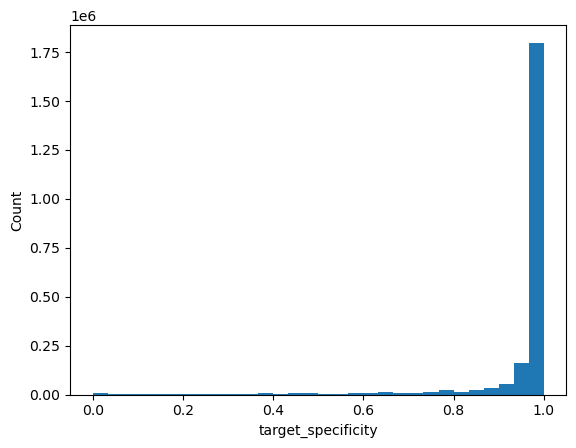

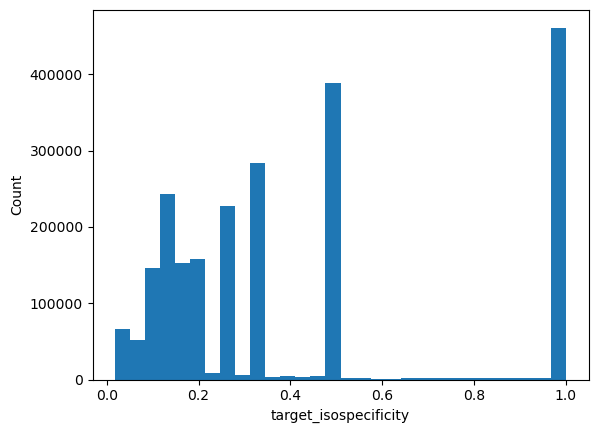

In [23]:
# Get the FPKMs of the transcripts
transcript_fpkms = dict(zip(list(transcriptome['transcript_id']), list(transcriptome['FPKM'])))

# Calculate the specificities and isoform specificities of the target regions
ot.calc_specificity(probe_dict, ottable_transcriptome, gene_ottable_dict, transcript_fpkms,
                    'target_sequence', 'target_specificity', 'target_isospecificity', 17)

plot.plot_hist(probe_dict, 'target_specificity')
plot.plot_hist(probe_dict, 'target_isospecificity')

In [24]:
# modify target isospecificity, if only one isoform exist:
for _gene, _transcript_2_df in probe_dict.items():
    if len(_transcript_2_df) == 1:
        for _transcript, _df in _transcript_2_df.items():
            probe_dict[_gene][_transcript]['target_isospecificity'] = 0.01

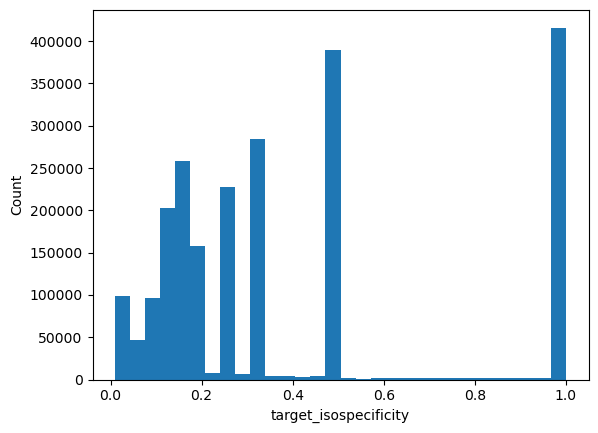

In [25]:
plot.plot_hist(probe_dict, 'target_isospecificity')

Trbc1
	ENSMUST00000192856.6: 148 / 504 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000103291.2: 104 / 453 probes passed the filter 0.99 < target_specificity <  inf.
Trbc2
	ENSMUST00000103299.3: 154 / 548 probes passed the filter 0.99 < target_specificity <  inf.
Trac
	ENSMUST00000198398.5: 507 / 653 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000103740.2: 234 / 321 probes passed the filter 0.99 < target_specificity <  inf.
Trgc1
	ENSMUST00000103558.3: 36 / 503 probes passed the filter 0.99 < target_specificity <  inf.
Trgc2
	ENSMUST00000103561.3: 41 / 501 probes passed the filter 0.99 < target_specificity <  inf.
Trgc4
	ENSMUST00000179181.3: 401 / 497 probes passed the filter 0.99 < target_specificity <  inf.
Igkc
	ENSMUST00000103410.3: 330 / 396 probes passed the filter 0.99 < target_specificity <  inf.
Ighm
	ENSMUST00000177715.8: 1115 / 1380 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000103426.3: 1027 / 1224 

c:\softwares\github\merfish_probe_design\MERFISH_probe_design\probe_design\filters.py:17: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  new_df = probe_dict[gk][tk][probe_dict[gk][tk][column_key].between(


	ENSMUST00000201964.4: 662 / 679 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000145918.5: 480 / 498 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000202474.4: 1436 / 1550 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000201081.2: 1118 / 1322 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000146908.2: 1570 / 2070 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000136019.3: 456 / 524 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000078486.13: 2992 / 3409 probes passed the filter 0.99 < target_specificity <  inf.
Ccr7
	ENSMUST00000103134.4: 1191 / 1634 probes passed the filter 0.99 < target_specificity <  inf.
Prdm1
	ENSMUST00000039174.11: 2318 / 3035 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000105490.3: 1833 / 2361 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000218369.2: 1487 / 1903 probes passed the 

	ENSMUST00000135993.8: 378 / 474 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000138452.2: 185 / 255 probes passed the filter 0.99 < target_specificity <  inf.
Cd69
	ENSMUST00000032259.6: 659 / 818 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000204411.2: 298 / 344 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000205190.3: 285 / 324 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000205032.2: 1166 / 1477 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000203727.2: 153 / 161 probes passed the filter 0.99 < target_specificity <  inf.
Itga2
	ENSMUST00000056117.10: 3242 / 4159 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000224204.2: 285 / 334 probes passed the filter 0.99 < target_specificity <  inf.
Il23a
	ENSMUST00000026449.3: 727 / 880 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000218109.2: 1106 / 1373 probes passed the filte

	ENSMUST00000182335.2: 1341 / 1871 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000189952.2: 2494 / 3092 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000194192.3: 3406 / 4722 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000182018.8: 3458 / 4439 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000185736.2: 457 / 666 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000183100.8: 458 / 565 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000182507.4: 525 / 601 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000115104.10: 13549 / 17456 probes passed the filter 0.99 < target_specificity <  inf.
Strip2
	ENSMUST00000151738.4: 2473 / 3257 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000137068.6: 1508 / 2051 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000115224.8: 1336 / 2062 probes passed the fil

	ENSMUST00000203275.3: 67 / 370 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000204819.3: 126 / 468 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000203150.2: 82 / 491 probes passed the filter 0.99 < target_specificity <  inf.
Tln1
	ENSMUST00000030187.14: 5611 / 7242 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000134623.2: 190 / 252 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000125509.2: 484 / 625 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000127262.2: 155 / 219 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000130670.2: 867 / 1090 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000130353.2: 591 / 729 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000126078.2: 169 / 223 probes passed the filter 0.99 < target_specificity <  inf.
	ENSMUST00000123985.2: 428 / 519 probes passed the filter 0.99 < target_s

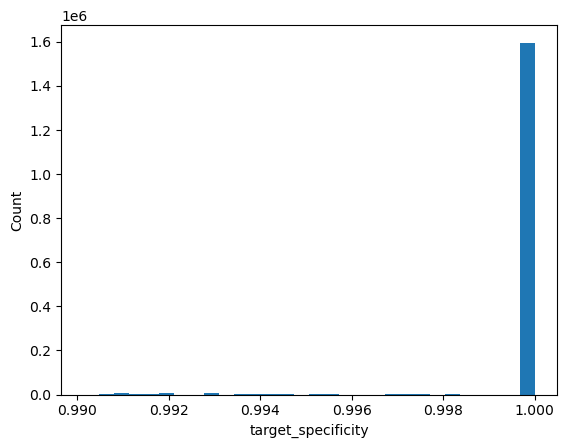

In [26]:
# Filter the specificities of the target regions
# Here we allow the probes to target other isoforms
# Don't allow any gene-level off-targets
filters.filter_probe_dict_by_metric(probe_dict, 'target_specificity', lower_bound=0.99)
plot.plot_hist(probe_dict, 'target_specificity')

In [27]:
## Select transcript based on length / number of possible probes:
largest_probe_th = 500
median_probe_th = 250


for _gene, _ts_2_pbs in probe_dict.items():
    pb_lens = []
    for _ts, _pbs in _ts_2_pbs.items():
        #print(_ts, len(_pbs))
        pb_lens.append(len(_pbs))
    if len(pb_lens) == 1:
        continue
    # filter
    if np.max(pb_lens) < largest_probe_th and np.median(pb_lens) < median_probe_th:
        print(_gene)
    #break

Trbc1
Iglc2
H2-DMb1
Rpl36a
Lilr4b
Lilrb4a
Ly6g
Ms4a4c
Ms4a6c
Klrd1
Rras
Itgam
Rgs10
Ly6i
Ly6a
Ly6c1
Mif
Atox1
Hmgb2
Ass1
Klrb1a
Dbi
Taldo1
Tnfsf12
Nme2


In [28]:
# Isoform selection
sel_pb_dict = {}
largest_probe_th = 1000
isospecificity_th = 0.5
for _gene, _ts_2_pbs in probe_dict.items():
    # case 1, only one transcript
    if len(_ts_2_pbs) == 1:
        sel_pb_dict[_gene] = _ts_2_pbs
    
    pb_lens = [len(_pbs) for _ts, _pbs in _ts_2_pbs.items()]
    general_pb_lens = [np.sum(_pbs['target_isospecificity'] <= isospecificity_th) 
                       for _ts, _pbs in _ts_2_pbs.items()]
    print(pb_lens, general_pb_lens)
    #break
    # case 2, multiple transcript, now try select nonspecific probes
    # select the transcript with the most common probes
    if np.max(general_pb_lens) > largest_probe_th:
        _t = list(_ts_2_pbs.keys())[general_pb_lens.index(np.max(general_pb_lens))]
        _pbs = _ts_2_pbs[_t]
        sel_pb_dict[_gene] = {_t: _pbs[_pbs['target_isospecificity'] <= largest_probe_th]}
    # case 3: none of transcript has enough common probes: select the one with the most common probes
    elif np.max(pb_lens) > largest_probe_th:
        _t = list(_ts_2_pbs.keys())[general_pb_lens.index(np.max(general_pb_lens))]
        _pbs = _ts_2_pbs[_t]
        sel_pb_dict[_gene] = {_t: _pbs}
    # case 4: all transcripts are short, select teh longest:
    else:
        _t = list(_ts_2_pbs.keys())[pb_lens.index(np.max(pb_lens))]
        _pbs = _ts_2_pbs[_t]
        sel_pb_dict[_gene] = {_t: _pbs}
        
        # check non-specific probes
        _pbs = list(_ts_2_pbs.values())[pb_lens.index(np.max(pb_lens))]
        if np.sum(_pbs['target_isospecificity'] <= isospecificity_th) > largest_probe_th:
            _t = list(_ts_2_pbs.keys())[pb_lens.index(np.max(pb_lens))]
            sel_pb_dict[_gene] = {_t: _pbs[_pbs['target_isospecificity'] <= largest_probe_th]}  
        # select the transcript with the most common probes
    print(_t, len(sel_pb_dict[_gene][_t]))


[148, 104] [94, 94]
ENSMUST00000192856.6 148
[154] [154]
ENSMUST00000103299.3 154
[507, 234] [234, 234]
ENSMUST00000198398.5 507
[36] [36]
ENSMUST00000103558.3 36
[41] [41]
ENSMUST00000103561.3 41
[401] [401]
ENSMUST00000179181.3 401
[330] [330]
ENSMUST00000103410.3 330
[1115, 1027] [915, 915]
ENSMUST00000177715.8 1115
[99] [99]
ENSMUST00000200235.2 99
[99, 153] [99, 99]
ENSMUST00000103749.3 153
[222, 2608, 461, 288, 1401, 3156] [0, 2583, 447, 280, 1213, 2508]
ENSMUST00000025523.13 2608
[449] [449]
ENSMUST00000096065.6 449
[174] [174]
ENSMUST00000092162.7 174
[3282, 1754, 2546, 2699, 1758, 1716, 1706, 671, 1859, 318] [3282, 1651, 2542, 2699, 1747, 1699, 1691, 670, 1782, 155]
ENSMUST00000161991.8 3282
[1153, 1200, 966, 864, 315, 310] [1027, 987, 962, 860, 315, 310]
ENSMUST00000235502.2 1153
[1227, 607, 565, 770, 499, 336] [768, 588, 562, 754, 483, 155]
ENSMUST00000059873.14 1227
[634, 2832, 624, 265] [595, 598, 550, 231]
ENSMUST00000132340.2 2832
[2766, 7962, 8158, 8141, 142, 1163, 1505

ENSMUST00000032194.11 1749
[1204, 1098, 352] [936, 936, 304]
ENSMUST00000032336.7 1204
[2573, 409, 2148] [2103, 346, 2103]
ENSMUST00000018610.7 2573
[2191, 297, 403, 330, 442, 108, 843] [948, 286, 401, 324, 410, 80, 843]
ENSMUST00000222517.2 2191
[247, 606, 362, 186, 434] [226, 587, 355, 185, 323]
ENSMUST00000193771.6 606
[2026, 1959, 903, 666, 1278] [1998, 1958, 755, 585, 497]
ENSMUST00000037491.11 2026
[648, 699] [621, 621]
ENSMUST00000126417.3 699
[2964, 1602, 1362, 1046, 747] [1602, 1590, 1362, 1027, 178]
ENSMUST00000105520.8 2964
[2245, 2127, 919, 398, 889, 316, 345, 1847, 1576, 856, 285, 1515, 748, 386, 328, 500, 410, 288, 608, 2224] [2217, 2127, 855, 268, 889, 314, 345, 1835, 1494, 840, 209, 1106, 71, 386, 322, 490, 301, 276, 172, 2217]
ENSMUST00000053748.16 2245
[2429, 1154, 1202, 715] [1316, 1154, 1191, 715]
ENSMUST00000028081.13 2429
[2941, 1585, 1423, 193, 1408] [1428, 929, 713, 68, 1408]
ENSMUST00000029106.13 2941
[962, 768, 1009] [626, 514, 350]
ENSMUST00000169159.3 962
[3

In [29]:
for _gene, _ts_2_pbs in sel_pb_dict.items():
    print(_gene, _ts_2_pbs.values())

Trbc1 dict_values([    gene_id         transcript_id  shift                 target_sequence  \
243   Trbc1  ENSMUST00000192856.6    243  TCTGGCACAATCCTCGCAACCACTTCCGCT   
244   Trbc1  ENSMUST00000192856.6    244  CTGGCACAATCCTCGCAACCACTTCCGCTG   
245   Trbc1  ENSMUST00000192856.6    245  TGGCACAATCCTCGCAACCACTTCCGCTGC   
246   Trbc1  ENSMUST00000192856.6    246  GGCACAATCCTCGCAACCACTTCCGCTGCC   
366   Trbc1  ENSMUST00000192856.6    366  GCCGAGCAGACTGTGGGATTACCTCAGCAT   
..      ...                   ...    ...                             ...   
674   Trbc1  ENSMUST00000192856.6    674  CTTGTGACCTGGAAAATGCCTACACTTACA   
677   Trbc1  ENSMUST00000192856.6    677  GTGACCTGGAAAATGCCTACACTTACAATC   
705   Trbc1  ENSMUST00000192856.6    705  TCAAACCAATAAACATGTTCTAGGACGGCC   
706   Trbc1  ENSMUST00000192856.6    706  CAAACCAATAAACATGTTCTAGGACGGCCT   
707   Trbc1  ENSMUST00000192856.6    707  AAACCAATAAACATGTTCTAGGACGGCCTG   

     target_GC  target_Tm  target_OT_rtRNA  target_specificity  \
24

Hfe dict_values([     gene_id          transcript_id  shift                 target_sequence  \
0        Hfe  ENSMUST00000091706.14      0  ATCAATGTCCCGGAAAGGGATCTAGCTTGT   
1        Hfe  ENSMUST00000091706.14      1  TCAATGTCCCGGAAAGGGATCTAGCTTGTC   
2        Hfe  ENSMUST00000091706.14      2  CAATGTCCCGGAAAGGGATCTAGCTTGTCA   
3        Hfe  ENSMUST00000091706.14      3  AATGTCCCGGAAAGGGATCTAGCTTGTCAG   
4        Hfe  ENSMUST00000091706.14      4  ATGTCCCGGAAAGGGATCTAGCTTGTCAGG   
...      ...                    ...    ...                             ...   
3515     Hfe  ENSMUST00000091706.14   3515  CTCTGTATGACTCTCCTCAAAGTGTGTGCA   
3516     Hfe  ENSMUST00000091706.14   3516  TCTGTATGACTCTCCTCAAAGTGTGTGCAA   
3517     Hfe  ENSMUST00000091706.14   3517  CTGTATGACTCTCCTCAAAGTGTGTGCAAC   
3518     Hfe  ENSMUST00000091706.14   3518  TGTATGACTCTCCTCAAAGTGTGTGCAACT   
3519     Hfe  ENSMUST00000091706.14   3519  GTATGACTCTCCTCAAAGTGTGTGCAACTA   

      target_GC  target_Tm  target_OT_rtRNA  t

Ahr dict_values([     gene_id         transcript_id  shift                 target_sequence  \
38       Ahr  ENSMUST00000116436.9     38  GGCGGCAGCGTGTGTGTGCGCTCCCTTTGA   
39       Ahr  ENSMUST00000116436.9     39  GCGGCAGCGTGTGTGTGCGCTCCCTTTGAC   
40       Ahr  ENSMUST00000116436.9     40  CGGCAGCGTGTGTGTGCGCTCCCTTTGACG   
41       Ahr  ENSMUST00000116436.9     41  GGCAGCGTGTGTGTGCGCTCCCTTTGACGC   
42       Ahr  ENSMUST00000116436.9     42  GCAGCGTGTGTGTGCGCTCCCTTTGACGCT   
...      ...                   ...    ...                             ...   
5307     Ahr  ENSMUST00000116436.9   5307  TACAGCACCTGAACACTTAACCAATATGCC   
5308     Ahr  ENSMUST00000116436.9   5308  ACAGCACCTGAACACTTAACCAATATGCCA   
5309     Ahr  ENSMUST00000116436.9   5309  CAGCACCTGAACACTTAACCAATATGCCAG   
5310     Ahr  ENSMUST00000116436.9   5310  AGCACCTGAACACTTAACCAATATGCCAGT   
5311     Ahr  ENSMUST00000116436.9   5311  GCACCTGAACACTTAACCAATATGCCAGTG   

      target_GC  target_Tm  target_OT_rtRNA  target_specif

Il17f dict_values([    gene_id          transcript_id  shift                 target_sequence  \
22    Il17f  ENSMUST00000039046.10     22  TAGAAGAAAGTACTTCCTGAGGGAAGAAGC   
23    Il17f  ENSMUST00000039046.10     23  AGAAGAAAGTACTTCCTGAGGGAAGAAGCA   
24    Il17f  ENSMUST00000039046.10     24  GAAGAAAGTACTTCCTGAGGGAAGAAGCAG   
25    Il17f  ENSMUST00000039046.10     25  AAGAAAGTACTTCCTGAGGGAAGAAGCAGC   
26    Il17f  ENSMUST00000039046.10     26  AGAAAGTACTTCCTGAGGGAAGAAGCAGCC   
..      ...                    ...    ...                             ...   
977   Il17f  ENSMUST00000039046.10    977  GACTGGCAAGGAAGAAGCACACATGGTATG   
978   Il17f  ENSMUST00000039046.10    978  ACTGGCAAGGAAGAAGCACACATGGTATGT   
979   Il17f  ENSMUST00000039046.10    979  CTGGCAAGGAAGAAGCACACATGGTATGTG   
980   Il17f  ENSMUST00000039046.10    980  TGGCAAGGAAGAAGCACACATGGTATGTGT   
981   Il17f  ENSMUST00000039046.10    981  GGCAAGGAAGAAGCACACATGGTATGTGTG   

     target_GC  target_Tm  target_OT_rtRNA  target_speci

Il23a dict_values([     gene_id         transcript_id  shift                 target_sequence  \
0      Il23a  ENSMUST00000026449.3      0  CGCTTAGAAGTCGGACTACAGAGTTAGACT   
7      Il23a  ENSMUST00000026449.3      7  AAGTCGGACTACAGAGTTAGACTCAGAACC   
8      Il23a  ENSMUST00000026449.3      8  AGTCGGACTACAGAGTTAGACTCAGAACCA   
9      Il23a  ENSMUST00000026449.3      9  GTCGGACTACAGAGTTAGACTCAGAACCAA   
10     Il23a  ENSMUST00000026449.3     10  TCGGACTACAGAGTTAGACTCAGAACCAAA   
...      ...                   ...    ...                             ...   
1204   Il23a  ENSMUST00000026449.3   1204  ACTACCACTATGACCTGTGACAAAGCTGCA   
1205   Il23a  ENSMUST00000026449.3   1205  CTACCACTATGACCTGTGACAAAGCTGCAT   
1206   Il23a  ENSMUST00000026449.3   1206  TACCACTATGACCTGTGACAAAGCTGCATA   
1207   Il23a  ENSMUST00000026449.3   1207  ACCACTATGACCTGTGACAAAGCTGCATAT   
1208   Il23a  ENSMUST00000026449.3   1208  CCACTATGACCTGTGACAAAGCTGCATATT   

      target_GC  target_Tm  target_OT_rtRNA  target_spec

Rhob dict_values([     gene_id         transcript_id  shift                 target_sequence  \
0       Rhob  ENSMUST00000067384.6      0  ATCTGCCACCGCAGTTCGGTTGTCGTCGTC   
1       Rhob  ENSMUST00000067384.6      1  TCTGCCACCGCAGTTCGGTTGTCGTCGTCT   
2       Rhob  ENSMUST00000067384.6      2  CTGCCACCGCAGTTCGGTTGTCGTCGTCTG   
3       Rhob  ENSMUST00000067384.6      3  TGCCACCGCAGTTCGGTTGTCGTCGTCTGC   
4       Rhob  ENSMUST00000067384.6      4  GCCACCGCAGTTCGGTTGTCGTCGTCTGCG   
...      ...                   ...    ...                             ...   
2173    Rhob  ENSMUST00000067384.6   2173  CCGCCAGCCCAGTGGTACTTCTAAATTGTC   
2174    Rhob  ENSMUST00000067384.6   2174  CGCCAGCCCAGTGGTACTTCTAAATTGTCT   
2175    Rhob  ENSMUST00000067384.6   2175  GCCAGCCCAGTGGTACTTCTAAATTGTCTT   
2176    Rhob  ENSMUST00000067384.6   2176  CCAGCCCAGTGGTACTTCTAAATTGTCTTG   
2177    Rhob  ENSMUST00000067384.6   2177  CAGCCCAGTGGTACTTCTAAATTGTCTTGT   

      target_GC  target_Tm  target_OT_rtRNA  target_speci

Ms4a1 dict_values([     gene_id         transcript_id  shift                 target_sequence  \
0      Ms4a1  ENSMUST00000169159.3      0  GGTGATTGGAGCGATTCTCAAGGTAGCAGA   
1      Ms4a1  ENSMUST00000169159.3      1  GTGATTGGAGCGATTCTCAAGGTAGCAGAA   
2      Ms4a1  ENSMUST00000169159.3      2  TGATTGGAGCGATTCTCAAGGTAGCAGAAG   
3      Ms4a1  ENSMUST00000169159.3      3  GATTGGAGCGATTCTCAAGGTAGCAGAAGC   
4      Ms4a1  ENSMUST00000169159.3      4  ATTGGAGCGATTCTCAAGGTAGCAGAAGCT   
...      ...                   ...    ...                             ...   
2872   Ms4a1  ENSMUST00000169159.3   2872  GTGGGAGGAGGAGTGTCAAGCTGAAAAGTT   
2873   Ms4a1  ENSMUST00000169159.3   2873  TGGGAGGAGGAGTGTCAAGCTGAAAAGTTT   
2874   Ms4a1  ENSMUST00000169159.3   2874  GGGAGGAGGAGTGTCAAGCTGAAAAGTTTT   
2875   Ms4a1  ENSMUST00000169159.3   2875  GGAGGAGGAGTGTCAAGCTGAAAAGTTTTA   
3045   Ms4a1  ENSMUST00000169159.3   3045  AAAGAATAAAAGTTCTTGTGAGCCTCCCCC   

      target_GC  target_Tm  target_OT_rtRNA  target_spec

Ear2 dict_values([    gene_id         transcript_id  shift                 target_sequence  \
23     Ear2  ENSMUST00000074839.7     23  GACAACCAGCCCTAAGTTCCACGGGAGCCA   
359    Ear2  ENSMUST00000074839.7    359  AGTTCATCTCGGGTACGTATAACTGTCTGT   
360    Ear2  ENSMUST00000074839.7    360  GTTCATCTCGGGTACGTATAACTGTCTGTA   
362    Ear2  ENSMUST00000074839.7    362  TCATCTCGGGTACGTATAACTGTCTGTAAC   
551    Ear2  ENSMUST00000074839.7    551  CAGCACTTTGCACCTTTGCTCATCTGCTAC   
552    Ear2  ENSMUST00000074839.7    552  AGCACTTTGCACCTTTGCTCATCTGCTACT   
553    Ear2  ENSMUST00000074839.7    553  GCACTTTGCACCTTTGCTCATCTGCTACTG   
554    Ear2  ENSMUST00000074839.7    554  CACTTTGCACCTTTGCTCATCTGCTACTGC   
616    Ear2  ENSMUST00000074839.7    616  GTCTGCGCTCCATATAGCACATGTCCTCGT   
617    Ear2  ENSMUST00000074839.7    617  TCTGCGCTCCATATAGCACATGTCCTCGTG   
618    Ear2  ENSMUST00000074839.7    618  CTGCGCTCCATATAGCACATGTCCTCGTGA   
619    Ear2  ENSMUST00000074839.7    619  TGCGCTCCATATAGCACATGTCCTCGTG

Ptprc dict_values([     gene_id         transcript_id  shift                 target_sequence  \
5      Ptprc  ENSMUST00000183301.8      5  TCTTAGGGTAAGAGAGTAGGAAACTTGCTC   
6      Ptprc  ENSMUST00000183301.8      6  CTTAGGGTAAGAGAGTAGGAAACTTGCTCC   
7      Ptprc  ENSMUST00000183301.8      7  TTAGGGTAAGAGAGTAGGAAACTTGCTCCC   
8      Ptprc  ENSMUST00000183301.8      8  TAGGGTAAGAGAGTAGGAAACTTGCTCCCC   
9      Ptprc  ENSMUST00000183301.8      9  AGGGTAAGAGAGTAGGAAACTTGCTCCCCA   
...      ...                   ...    ...                             ...   
4875   Ptprc  ENSMUST00000183301.8   4875  GGTAACCTCGTACAGTTAGTTCTGTTATGG   
4933   Ptprc  ENSMUST00000183301.8   4933  TGACTATGGCCATTTCCTATGCTTAAGACC   
4934   Ptprc  ENSMUST00000183301.8   4934  GACTATGGCCATTTCCTATGCTTAAGACCA   
4936   Ptprc  ENSMUST00000183301.8   4936  CTATGGCCATTTCCTATGCTTAAGACCATC   
4940   Ptprc  ENSMUST00000183301.8   4940  GGCCATTTCCTATGCTTAAGACCATCTTTG   

      target_GC  target_Tm  target_OT_rtRNA  target_spec

Slpi dict_values([    gene_id          transcript_id  shift                 target_sequence  \
0      Slpi  ENSMUST00000109367.10      0  GCTTCTGTCATTTTCAGCTCTCAGGTGGTT   
1      Slpi  ENSMUST00000109367.10      1  CTTCTGTCATTTTCAGCTCTCAGGTGGTTA   
2      Slpi  ENSMUST00000109367.10      2  TTCTGTCATTTTCAGCTCTCAGGTGGTTAC   
3      Slpi  ENSMUST00000109367.10      3  TCTGTCATTTTCAGCTCTCAGGTGGTTACT   
4      Slpi  ENSMUST00000109367.10      4  CTGTCATTTTCAGCTCTCAGGTGGTTACTC   
..      ...                    ...    ...                             ...   
801    Slpi  ENSMUST00000109367.10    801  TGGCTCAGCATTCACCGATCTTTAGGGAAA   
802    Slpi  ENSMUST00000109367.10    802  GGCTCAGCATTCACCGATCTTTAGGGAAAT   
803    Slpi  ENSMUST00000109367.10    803  GCTCAGCATTCACCGATCTTTAGGGAAATG   
804    Slpi  ENSMUST00000109367.10    804  CTCAGCATTCACCGATCTTTAGGGAAATGC   
805    Slpi  ENSMUST00000109367.10    805  TCAGCATTCACCGATCTTTAGGGAAATGCT   

     target_GC  target_Tm  target_OT_rtRNA  target_specif

Cd79b dict_values([     gene_id          transcript_id  shift                 target_sequence  \
14     Cd79b  ENSMUST00000044228.11     14  CAACCCCTTCCCAGGGGGTCTCTCAAGAAC   
15     Cd79b  ENSMUST00000044228.11     15  AACCCCTTCCCAGGGGGTCTCTCAAGAACC   
16     Cd79b  ENSMUST00000044228.11     16  ACCCCTTCCCAGGGGGTCTCTCAAGAACCC   
17     Cd79b  ENSMUST00000044228.11     17  CCCCTTCCCAGGGGGTCTCTCAAGAACCCA   
18     Cd79b  ENSMUST00000044228.11     18  CCCTTCCCAGGGGGTCTCTCAAGAACCCAA   
...      ...                    ...    ...                             ...   
1382   Cd79b  ENSMUST00000044228.11   1382  AGCCTACAGCCCATCCTCCTGTGGAATAAA   
1383   Cd79b  ENSMUST00000044228.11   1383  GCCTACAGCCCATCCTCCTGTGGAATAAAT   
1384   Cd79b  ENSMUST00000044228.11   1384  CCTACAGCCCATCCTCCTGTGGAATAAATA   
1385   Cd79b  ENSMUST00000044228.11   1385  CTACAGCCCATCCTCCTGTGGAATAAATAA   
1387   Cd79b  ENSMUST00000044228.11   1387  ACAGCCCATCCTCCTGTGGAATAAATAATG   

      target_GC  target_Tm  target_OT_rtRNA 

In [30]:
p_d.print_probe_dict(sel_pb_dict) # We excluded all the transcripts that are not our direct targets

Gene	Transcript	N_probes
Trbc1
	ENSMUST00000192856.6	148
Trbc2
	ENSMUST00000103299.3	154
Trac
	ENSMUST00000198398.5	507
Trgc1
	ENSMUST00000103558.3	36
Trgc2
	ENSMUST00000103561.3	41
Trgc4
	ENSMUST00000179181.3	401
Igkc
	ENSMUST00000103410.3	330
Ighm
	ENSMUST00000177715.8	1115
Iglc3
	ENSMUST00000200235.2	99
Iglc2
	ENSMUST00000103749.3	153
Csf1r
	ENSMUST00000025523.13	2608
Tigit
	ENSMUST00000096065.6	449
Lyz1
	ENSMUST00000092162.7	174
Tbc1d4
	ENSMUST00000161991.8	3282
Ctsw
	ENSMUST00000235502.2	1153
Treml4
	ENSMUST00000059873.14	1227
Trem2
	ENSMUST00000132340.2	2832
Mycbp2
	ENSMUST00000159855.8	8141
Fos
	ENSMUST00000140525.8	510
Hfe
	ENSMUST00000091706.14	1666
Aicda
	ENSMUST00000043301.14	1259
Srrm2
	ENSMUST00000190686.7	5049
Il22
	ENSMUST00000096691.5	38
Ifng
	ENSMUST00000068592.5	504
Ets1
	ENSMUST00000034534.13	2484
Clec4a3
	ENSMUST00000088468.7	320
Ceacam1
	ENSMUST00000098666.9	329
Cd8a
	ENSMUST00000066747.14	1464
Adgre4
	ENSMUST00000025004.7	1183
Cd19
	ENSMUST00000206325.2	1555
Il7r


## save probe_dict

In [32]:
import pickle
full_probe_filename = os.path.join(library_folder, 
                                   f"{time.localtime().tm_year}_{time.localtime().tm_mon}_{time.localtime().tm_mday}_full_probe_isoforms.pkl")
print(full_probe_filename)
pickle.dump(probe_dict, open(full_probe_filename, 'wb'))

\\wi-bigdata.wi.mit.edu\solexa_weissman\puzheng\MERFISH_Probes\Brain_MS_immune\2023_7_5_full_probe_isoforms.pkl


In [33]:
# delete
del(probe_dict)

## Readouts

In [34]:
# load readouts
print(f"Loading readouts from file: {readout_savefile}")
readouts = pd.read_csv(readout_savefile)

Loading readouts from file: \\wi-bigdata.wi.mit.edu\solexa_weissman\puzheng\MERFISH_Probes\Brain_MS_immune\readouts.csv


In [35]:
# modify Stv into standard sequence
readout_seqs = pd.DataFrame(
    {'id':readouts['Name'], 'description':readouts['Name'], 'sequence':[_s[-20:] for _s in readouts['Sequence']]}
)
rs.append_on_bit_ids_to_readout_sequences(readout_seqs, bit_names)

In [36]:
readout_seqs

,id,description,sequence,on-bit
0,Stv_3,Stv_3,CCAGATCGGACGATCATGGG,0
1,Stv_4,Stv_4,GCGCGATTGACCGTCTCGTT,1
2,Stv_5,Stv_5,CCGATGCGCAGCAATTCACT,2
3,Stv_6,Stv_6,GCCACGGTCCCGTTGAACTT,3
4,Stv_7,Stv_7,CGTCCAGCGCGTCAAACAGA,4
5,Stv_8,Stv_8,CCGTAACGAGCGTCCCTTGC,5
6,Stv_9,Stv_9,CCTGGCGTTGCGACGACTAA,6
7,Stv_10,Stv_10,CGGTCCACCGTTGCGCTTAC,7
8,Stv_11,Stv_11,CCAGGTCCGTCACGCAATTT,8
9,Stv_12,Stv_12,CGGAGCGTAGCGGAATCTGC,9


In [37]:
barcode_table

,name,id,barcode_str
0,Mmp25,,0000000010000010011000
1,Ms4a1,,0010000010000000010001
2,Il17f,,1000000001001001000000
3,Il22,,1110100000000000000000
4,Tanc2,,0001001000001000000001
...,...,...,...
309,Blank-16,,0000010010010000001000
310,Blank-17,,1101000000000000000001
311,Blank-18,,1100000011000000000000
312,Blank-19,,0000000100011000100000


In [38]:
# Add the readout sequences. Here we randomly add 4 readout sequences to each probe.
# Add an "T" between the concatenated sequences.
# Force each probe to have the same readout sequence
num_readouts = 4

rs.add_readout_seqs_to_probes_random(sel_pb_dict, readout_seqs, barcode_table, 4, 
                                     n_threads=12,
                                     spacer='', gene_id_key='name', each_probe_1_on_bit=True) 
# if each_probe_1_on_bit set to be true, each probe will have 4 of the same readout sequence

In [39]:
%%time
# and minimizes the overlapping between probes.
ps.select_probes_greedy_stochastic(sel_pb_dict, N_probes_per_transcript=96, 
                                   N_on_bits=4, N_threads=12)

# Primer

In [40]:
# Load the primer candidates into data frames
forward_primers, reverse_primers = fio.load_primers(forward_primer_file, reverse_primer_file)
display(forward_primers)
display(reverse_primers)

,id,description,sequence,sequence_rc
0,W1A01_primer_0,W1A01_primer_0,CGGCTCGCAGCGTGTAAACG,CGTTTACACGCTGCGAGCCG
1,W1A03_primer_2,W1A03_primer_2,CCCGCAATGGCTGACAACCG,CGGTTGTCAGCCATTGCGGG
2,W1A05_primer_4,W1A05_primer_4,CATTCAGCATTGCGCAACGG,CCGTTGCGCAATGCTGAATG
3,W1A07_primer_6,W1A07_primer_6,CGCAAACTGGTGCGGAAGGC,GCCTTCCGCACCAGTTTGCG
4,W1A09_primer_8,W1A09_primer_8,TTGTTGAGGCGGCGGAAGTC,GACTTCCGCCGCCTCAACAA
5,W1A11_primer_10,W1A11_primer_10,TTGCTAGCGTGGGCCAATCG,CGATTGGCCCACGCTAGCAA
6,W1B01_primer_12,W1B01_primer_12,TTGGGCGTGCACGTCAATTC,GAATTGACGTGCACGCCCAA
7,W1B03_primer_14,W1B03_primer_14,GACATCCAGGCGCGGACAAC,GTTGTCCGCGCCTGGATGTC
8,W1B05_primer_16,W1B05_primer_16,CGGGTTTCGTTGCGCACACC,GGTGTGCGCAACGAAACCCG
9,W1B07_primer_18,W1B07_primer_18,CACGTGGCCTCTCGCACATC,GATGTGCGAGAGGCCACGTG


,id,description,sequence,sequence_rc
0,W1A02_primer_1,W1A02_primer_1,TAATACGACTCACTATAGGGCATTTCAGGATCACCGGCGG,CCGCCGGTGATCCTGAAATGCCCTATAGTGAGTCGTATTA
1,W1A04_primer_3,W1A04_primer_3,TAATACGACTCACTATAGGGCGTTGTATGCCCTCCACGC,GCGTGGAGGGCATACAACGCCCTATAGTGAGTCGTATTA
2,W1A06_primer_5,W1A06_primer_5,TAATACGACTCACTATAGGGTCTTCCCGCAAATGCACCG,CGGTGCATTTGCGGGAAGACCCTATAGTGAGTCGTATTA
3,W1A08_primer_7,W1A08_primer_7,TAATACGACTCACTATAGGGCCCTTTCGCGCTGCATCGAC,GTCGATGCAGCGCGAAAGGGCCCTATAGTGAGTCGTATTA
4,W1A10_primer_9,W1A10_primer_9,TAATACGACTCACTATAGGGATTGCCGCATGGTTTCCG,CGGAAACCATGCGGCAATCCCTATAGTGAGTCGTATTA
5,W1A12_primer_11,W1A12_primer_11,TAATACGACTCACTATAGGGCCATTGCCCGCGAGGTCGAG,CTCGACCTCGCGGGCAATGGCCCTATAGTGAGTCGTATTA
6,W1B04_primer_15,W1B04_primer_15,TAATACGACTCACTATAGGGCTTGTGCATCGCGCCAAAGA,TCTTTGGCGCGATGCACAAGCCCTATAGTGAGTCGTATTA
7,W1B06_primer_17,W1B06_primer_17,TAATACGACTCACTATAGGGCCTGTGCGGAAATCGCGAGA,TCTCGCGATTTCCGCACAGGCCCTATAGTGAGTCGTATTA
8,W1B10_primer_21,W1B10_primer_21,TAATACGACTCACTATAGGGCGGGTCGATCATCGGCTTTG,CAAAGCCGATGATCGACCCGCCCTATAGTGAGTCGTATTA


In [41]:
# Selet primers
# Make an off-target from the current probe sequences.
ottable_target_readout = ot.get_OTTable_for_probe_dictionary(sel_pb_dict, 'target_readout_sequence', 15)

# Calculate the off-targets for the primer sequences and their reverse-complements
# Usually, there shouln't be any off-targets
ot.calc_OTs_df(forward_primers, ottable_target_readout, 'sequence', 'sequence_OT', 15)
ot.calc_OTs_df(forward_primers, ottable_target_readout, 'sequence_rc', 'sequence_rc_OT', 15)
ot.calc_OTs_df(reverse_primers, ottable_target_readout, 'sequence', 'sequence_OT', 15)
ot.calc_OTs_df(reverse_primers, ottable_target_readout, 'sequence_rc', 'sequence_rc_OT', 15)
# Display primer OT tables to manually select
display(forward_primers)
display(reverse_primers)

,id,description,sequence,sequence_rc,sequence_OT,sequence_rc_OT
0,W1A01_primer_0,W1A01_primer_0,CGGCTCGCAGCGTGTAAACG,CGTTTACACGCTGCGAGCCG,0,0
1,W1A03_primer_2,W1A03_primer_2,CCCGCAATGGCTGACAACCG,CGGTTGTCAGCCATTGCGGG,0,0
2,W1A05_primer_4,W1A05_primer_4,CATTCAGCATTGCGCAACGG,CCGTTGCGCAATGCTGAATG,0,0
3,W1A07_primer_6,W1A07_primer_6,CGCAAACTGGTGCGGAAGGC,GCCTTCCGCACCAGTTTGCG,0,0
4,W1A09_primer_8,W1A09_primer_8,TTGTTGAGGCGGCGGAAGTC,GACTTCCGCCGCCTCAACAA,0,0
5,W1A11_primer_10,W1A11_primer_10,TTGCTAGCGTGGGCCAATCG,CGATTGGCCCACGCTAGCAA,0,0
6,W1B01_primer_12,W1B01_primer_12,TTGGGCGTGCACGTCAATTC,GAATTGACGTGCACGCCCAA,0,0
7,W1B03_primer_14,W1B03_primer_14,GACATCCAGGCGCGGACAAC,GTTGTCCGCGCCTGGATGTC,0,0
8,W1B05_primer_16,W1B05_primer_16,CGGGTTTCGTTGCGCACACC,GGTGTGCGCAACGAAACCCG,0,0
9,W1B07_primer_18,W1B07_primer_18,CACGTGGCCTCTCGCACATC,GATGTGCGAGAGGCCACGTG,0,0


,id,description,sequence,sequence_rc,sequence_OT,sequence_rc_OT
0,W1A02_primer_1,W1A02_primer_1,TAATACGACTCACTATAGGGCATTTCAGGATCACCGGCGG,CCGCCGGTGATCCTGAAATGCCCTATAGTGAGTCGTATTA,0,0
1,W1A04_primer_3,W1A04_primer_3,TAATACGACTCACTATAGGGCGTTGTATGCCCTCCACGC,GCGTGGAGGGCATACAACGCCCTATAGTGAGTCGTATTA,0,0
2,W1A06_primer_5,W1A06_primer_5,TAATACGACTCACTATAGGGTCTTCCCGCAAATGCACCG,CGGTGCATTTGCGGGAAGACCCTATAGTGAGTCGTATTA,0,0
3,W1A08_primer_7,W1A08_primer_7,TAATACGACTCACTATAGGGCCCTTTCGCGCTGCATCGAC,GTCGATGCAGCGCGAAAGGGCCCTATAGTGAGTCGTATTA,0,0
4,W1A10_primer_9,W1A10_primer_9,TAATACGACTCACTATAGGGATTGCCGCATGGTTTCCG,CGGAAACCATGCGGCAATCCCTATAGTGAGTCGTATTA,0,0
5,W1A12_primer_11,W1A12_primer_11,TAATACGACTCACTATAGGGCCATTGCCCGCGAGGTCGAG,CTCGACCTCGCGGGCAATGGCCCTATAGTGAGTCGTATTA,0,0
6,W1B04_primer_15,W1B04_primer_15,TAATACGACTCACTATAGGGCTTGTGCATCGCGCCAAAGA,TCTTTGGCGCGATGCACAAGCCCTATAGTGAGTCGTATTA,0,0
7,W1B06_primer_17,W1B06_primer_17,TAATACGACTCACTATAGGGCCTGTGCGGAAATCGCGAGA,TCTCGCGATTTCCGCACAGGCCCTATAGTGAGTCGTATTA,0,0
8,W1B10_primer_21,W1B10_primer_21,TAATACGACTCACTATAGGGCGGGTCGATCATCGGCTTTG,CAAAGCCGATGATCGACCCGCCCTATAGTGAGTCGTATTA,0,0


In [42]:
forward_primers = pd.DataFrame(forward_primers.loc[forward_primers['id']=='W1A03_primer_2'],)
reverse_primers = pd.DataFrame(reverse_primers[reverse_primers['id']=='W1A10_primer_9'], index=None)

In [43]:
# Add the primer sequences

# NOTE: the sequence after primer addition should be (reverse_primer)-(target_readouts)-(forward_primer_rc)
primer_design.add_primer_sequences(sel_pb_dict, 
                                   reverse_primers.iloc[0]['sequence'][-20:], 
                                   forward_primers.iloc[0]['sequence_rc'], ## In this case don't add forward primers at all
                input_column='target_readout_sequence', output_column='target_readout_primer_sequence')

# Notice that the T7 promoter (the first 17 bases of the reverse primer) will be lost after in vitro transcription
# create a column of the T7 transcribed sequences for the subsequent quality check
primer_design.add_primer_sequences(sel_pb_dict, 
                reverse_primers.iloc[0]['sequence'][17:], forward_primers.iloc[0]['sequence_rc'],
                input_column='target_readout_sequence', output_column='target_readout_primer_sequence_t7_transcribed')

In [44]:
print(selected_primers_file)
merged_primer_df = pd.concat([forward_primers, reverse_primers], ignore_index=True)
merged_primer_df.to_csv(selected_primers_file)
merged_primer_df

\\wi-bigdata.wi.mit.edu\solexa_weissman\puzheng\MERFISH_Probes\Brain_MS_immune\selected_primers.csv


,id,description,sequence,sequence_rc,sequence_OT,sequence_rc_OT
0,W1A03_primer_2,W1A03_primer_2,CCCGCAATGGCTGACAACCG,CGGTTGTCAGCCATTGCGGG,0,0
1,W1A10_primer_9,W1A10_primer_9,TAATACGACTCACTATAGGGATTGCCGCATGGTTTCCG,CGGAAACCATGCGGCAATCCCTATAGTGAGTCGTATTA,0,0


# Quality check

In [45]:
sel_pb_dict['Trbc1']['ENSMUST00000192856.6']

,gene_id,transcript_id,shift,target_sequence,target_GC,target_Tm,target_OT_rtRNA,target_specificity,target_isospecificity,readout_names,probe_barcode,target_readout_sequence,target_readout_primer_sequence,target_readout_primer_sequence_t7_transcribed
373,Trbc1,ENSMUST00000192856.6,373,AGACTGTGGGATTACCTCAGCATCCTATCA,46.666667,53.390138,0,1.0,0.500000,Stv_7:Stv_7::Stv_7:Stv_7,0000100000000000000000,CGTCCAGCGCGTCAAACAGACGTCCAGCGCGTCAAACAGAAGACTG...,GGATTGCCGCATGGTTTCCGCGTCCAGCGCGTCAAACAGACGTCCA...,GGGATTGCCGCATGGTTTCCGCGTCCAGCGCGTCAAACAGACGTCC...
459,Trbc1,ENSMUST00000192856.6,459,TGTATGCTGTGCTTGTCAGTACACTGGTGG,50.000000,54.277536,0,1.0,0.500000,Stv_11:Stv_11::Stv_11:Stv_11,0000000010000000000000,CCAGGTCCGTCACGCAATTTCCAGGTCCGTCACGCAATTTTGTATG...,GGATTGCCGCATGGTTTCCGCCAGGTCCGTCACGCAATTTCCAGGT...,GGGATTGCCGCATGGTTTCCGCCAGGTCCGTCACGCAATTTCCAGG...
634,Trbc1,ENSMUST00000192856.6,634,CCTACTAGTCACGCATAGGTGCATTTGTAT,43.333333,51.486829,0,1.0,1.000000,Stv_14:Stv_14::Stv_14:Stv_14,0000000000010000000000,CGACGGATGTAATTCGGCCGCGACGGATGTAATTCGGCCGCCTACT...,GGATTGCCGCATGGTTTCCGCGACGGATGTAATTCGGCCGCGACGG...,GGGATTGCCGCATGGTTTCCGCGACGGATGTAATTCGGCCGCGACG...
428,Trbc1,ENSMUST00000192856.6,428,CTCTATGAGATCCTGCTAGGGAAAGCCACC,53.333333,54.843677,0,1.0,0.500000,Stv_23:Stv_23::Stv_23:Stv_23,0000000000000000010000,GTGGGCTGCTGCGATTTCACGTGGGCTGCTGCGATTTCACCTCTAT...,GGATTGCCGCATGGTTTCCGGTGGGCTGCTGCGATTTCACGTGGGC...,GGGATTGCCGCATGGTTTCCGGTGGGCTGCTGCGATTTCACGTGGG...
580,Trbc1,ENSMUST00000192856.6,580,TCTCCCAGAACTTCTGAAGAGCTATTCTCA,43.333333,50.351788,0,1.0,1.000000,Stv_11:Stv_11::Stv_11:Stv_11,0000000010000000000000,CCAGGTCCGTCACGCAATTTCCAGGTCCGTCACGCAATTTTCTCCC...,GGATTGCCGCATGGTTTCCGCCAGGTCCGTCACGCAATTTCCAGGT...,GGGATTGCCGCATGGTTTCCGCCAGGTCCGTCACGCAATTTCCAGG...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378,Trbc1,ENSMUST00000192856.6,378,GTGGGATTACCTCAGCATCCTATCAACAAG,46.666667,51.953331,0,1.0,0.500000,Stv_23:Stv_23::Stv_23:Stv_23,0000000000000000010000,GTGGGCTGCTGCGATTTCACGTGGGCTGCTGCGATTTCACGTGGGA...,GGATTGCCGCATGGTTTCCGGTGGGCTGCTGCGATTTCACGTGGGC...,GGGATTGCCGCATGGTTTCCGGTGGGCTGCTGCGATTTCACGTGGG...
475,Trbc1,ENSMUST00000192856.6,475,CAGTACACTGGTGGTGATGGCTATGGTCAA,50.000000,54.774297,0,1.0,0.607143,Stv_11:Stv_11::Stv_11:Stv_11,0000000010000000000000,CCAGGTCCGTCACGCAATTTCCAGGTCCGTCACGCAATTTCAGTAC...,GGATTGCCGCATGGTTTCCGCCAGGTCCGTCACGCAATTTCCAGGT...,GGGATTGCCGCATGGTTTCCGCCAGGTCCGTCACGCAATTTCCAGG...
625,Trbc1,ENSMUST00000192856.6,625,CAAATTCTGCCTACTAGTCACGCATAGGTG,46.666667,51.746370,0,1.0,1.000000,Stv_14:Stv_14::Stv_14:Stv_14,0000000000010000000000,CGACGGATGTAATTCGGCCGCGACGGATGTAATTCGGCCGCAAATT...,GGATTGCCGCATGGTTTCCGCGACGGATGTAATTCGGCCGCGACGG...,GGGATTGCCGCATGGTTTCCGCGACGGATGTAATTCGGCCGCGACG...
398,Trbc1,ENSMUST00000192856.6,398,TATCAACAAGGGGTCTTGTCTGCCACCATC,50.000000,55.070520,0,1.0,0.500000,Stv_11:Stv_11::Stv_11:Stv_11,0000000010000000000000,CCAGGTCCGTCACGCAATTTCCAGGTCCGTCACGCAATTTTATCAA...,GGATTGCCGCATGGTTTCCGCCAGGTCCGTCACGCAATTTCCAGGT...,GGGATTGCCGCATGGTTTCCGCCAGGTCCGTCACGCAATTTCCAGG...


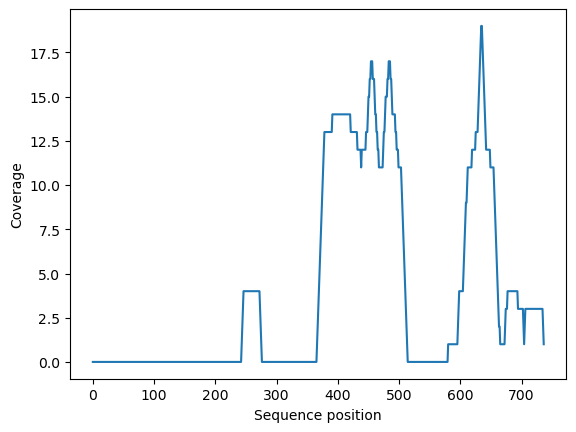

In [46]:
# Let's plot the probe coverage of an example transcript
seq_len = len(transcriptome[transcriptome['transcript_id'] == 'ENSMUST00000192856.6'].iloc[0]['sequence'])
plot.plot_sequence_coverage(sel_pb_dict['Trbc1']['ENSMUST00000192856.6'], seq_len)

Calculate OTs for 0/294 genes.
Calculate OTs for 1/294 genes.
Calculate OTs for 2/294 genes.
Calculate OTs for 3/294 genes.
Calculate OTs for 4/294 genes.
Calculate OTs for 5/294 genes.
Calculate OTs for 6/294 genes.
Calculate OTs for 7/294 genes.
Calculate OTs for 8/294 genes.
Calculate OTs for 9/294 genes.
Calculate OTs for 10/294 genes.
Calculate OTs for 11/294 genes.
Calculate OTs for 12/294 genes.
Calculate OTs for 13/294 genes.
Calculate OTs for 14/294 genes.
Calculate OTs for 15/294 genes.
Calculate OTs for 16/294 genes.
Calculate OTs for 17/294 genes.
Calculate OTs for 18/294 genes.
Calculate OTs for 19/294 genes.
Calculate OTs for 20/294 genes.
Calculate OTs for 21/294 genes.
Calculate OTs for 22/294 genes.
Calculate OTs for 23/294 genes.
Calculate OTs for 24/294 genes.
Calculate OTs for 25/294 genes.
Calculate OTs for 26/294 genes.
Calculate OTs for 27/294 genes.
Calculate OTs for 28/294 genes.
Calculate OTs for 29/294 genes.
Calculate OTs for 30/294 genes.
Calculate OTs for 

c:\softwares\github\merfish_probe_design\MERFISH_probe_design\probe_design\filters.py:17: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated in favour of `both` or `neither`.
  new_df = probe_dict[gk][tk][probe_dict[gk][tk][column_key].between(


	ENSMUST00000192856.6: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  38.5.
Trbc2
	ENSMUST00000103299.3: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  38.5.
Trac
	ENSMUST00000198398.5: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  38.5.
Trgc1
	ENSMUST00000103558.3: 36 / 36 probes passed the filter -inf < probe_cis_trans_OT <  38.5.
Trgc2
	ENSMUST00000103561.3: 41 / 41 probes passed the filter -inf < probe_cis_trans_OT <  38.5.
Trgc4
	ENSMUST00000179181.3: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  38.5.
Igkc
	ENSMUST00000103410.3: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  38.5.
Ighm
	ENSMUST00000177715.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  38.5.
Iglc3
	ENSMUST00000200235.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  38.5.
Iglc2
	ENSMUST00000103749.3: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  38.5.
Csf1r
	ENSMUST00000025523.13: 96 / 96 p

Calculate OTs for 0/294 genes.
Calculate OTs for 1/294 genes.
Calculate OTs for 2/294 genes.
Calculate OTs for 3/294 genes.
Calculate OTs for 4/294 genes.
Calculate OTs for 5/294 genes.
Calculate OTs for 6/294 genes.
Calculate OTs for 7/294 genes.
Calculate OTs for 8/294 genes.
Calculate OTs for 9/294 genes.
Calculate OTs for 10/294 genes.
Calculate OTs for 11/294 genes.
Calculate OTs for 12/294 genes.
Calculate OTs for 13/294 genes.
Calculate OTs for 14/294 genes.
Calculate OTs for 15/294 genes.
Calculate OTs for 16/294 genes.
Calculate OTs for 17/294 genes.
Calculate OTs for 18/294 genes.
Calculate OTs for 19/294 genes.
Calculate OTs for 20/294 genes.
Calculate OTs for 21/294 genes.
Calculate OTs for 22/294 genes.
Calculate OTs for 23/294 genes.
Calculate OTs for 24/294 genes.
Calculate OTs for 25/294 genes.
Calculate OTs for 26/294 genes.
Calculate OTs for 27/294 genes.
Calculate OTs for 28/294 genes.
Calculate OTs for 29/294 genes.
Calculate OTs for 30/294 genes.
Calculate OTs for 

Calculate OTs for 266/294 genes.
Calculate OTs for 267/294 genes.
Calculate OTs for 268/294 genes.
Calculate OTs for 269/294 genes.
Calculate OTs for 270/294 genes.
Calculate OTs for 271/294 genes.
Calculate OTs for 272/294 genes.
Calculate OTs for 273/294 genes.
Calculate OTs for 274/294 genes.
Calculate OTs for 275/294 genes.
Calculate OTs for 276/294 genes.
Calculate OTs for 277/294 genes.
Calculate OTs for 278/294 genes.
Calculate OTs for 279/294 genes.
Calculate OTs for 280/294 genes.
Calculate OTs for 281/294 genes.
Calculate OTs for 282/294 genes.
Calculate OTs for 283/294 genes.
Calculate OTs for 284/294 genes.
Calculate OTs for 285/294 genes.
Calculate OTs for 286/294 genes.
Calculate OTs for 287/294 genes.
Calculate OTs for 288/294 genes.
Calculate OTs for 289/294 genes.
Calculate OTs for 290/294 genes.
Calculate OTs for 291/294 genes.
Calculate OTs for 292/294 genes.
Calculate OTs for 293/294 genes.
Trbc1
	ENSMUST00000192856.6: 96 / 96 probes passed the filter -inf < probe_c

	ENSMUST00000222705.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  19.5.
Tcf7
	ENSMUST00000086844.10: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  19.5.
Cd80
	ENSMUST00000231716.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  19.5.
Bcl6
	ENSMUST00000023151.6: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  19.5.
Dst
	ENSMUST00000097785.10: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  19.5.
Strip2
	ENSMUST00000151738.4: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  19.5.
Grina
	ENSMUST00000023225.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  19.5.
Il4
	ENSMUST00000000889.7: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  19.5.
Cd28
	ENSMUST00000027165.3: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  19.5.
Cd37
	ENSMUST00000209779.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  19.5.
Ctla4
	ENSMUST00000027164.9: 96 / 96 probe

Calculate OTs for 0/294 genes.
Calculate OTs for 1/294 genes.
Calculate OTs for 2/294 genes.
Calculate OTs for 3/294 genes.
Calculate OTs for 4/294 genes.
Calculate OTs for 5/294 genes.
Calculate OTs for 6/294 genes.
Calculate OTs for 7/294 genes.
Calculate OTs for 8/294 genes.
Calculate OTs for 9/294 genes.
Calculate OTs for 10/294 genes.
Calculate OTs for 11/294 genes.
Calculate OTs for 12/294 genes.
Calculate OTs for 13/294 genes.
Calculate OTs for 14/294 genes.
Calculate OTs for 15/294 genes.
Calculate OTs for 16/294 genes.
Calculate OTs for 17/294 genes.
Calculate OTs for 18/294 genes.
Calculate OTs for 19/294 genes.
Calculate OTs for 20/294 genes.
Calculate OTs for 21/294 genes.
Calculate OTs for 22/294 genes.
Calculate OTs for 23/294 genes.
Calculate OTs for 24/294 genes.
Calculate OTs for 25/294 genes.
Calculate OTs for 26/294 genes.
Calculate OTs for 27/294 genes.
Calculate OTs for 28/294 genes.
Calculate OTs for 29/294 genes.
Calculate OTs for 30/294 genes.
Calculate OTs for 

Calculate OTs for 275/294 genes.
Calculate OTs for 276/294 genes.
Calculate OTs for 277/294 genes.
Calculate OTs for 278/294 genes.
Calculate OTs for 279/294 genes.
Calculate OTs for 280/294 genes.
Calculate OTs for 281/294 genes.
Calculate OTs for 282/294 genes.
Calculate OTs for 283/294 genes.
Calculate OTs for 284/294 genes.
Calculate OTs for 285/294 genes.
Calculate OTs for 286/294 genes.
Calculate OTs for 287/294 genes.
Calculate OTs for 288/294 genes.
Calculate OTs for 289/294 genes.
Calculate OTs for 290/294 genes.
Calculate OTs for 291/294 genes.
Calculate OTs for 292/294 genes.
Calculate OTs for 293/294 genes.
Trbc1
	ENSMUST00000192856.6: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  16.5.
Trbc2
	ENSMUST00000103299.3: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  16.5.
Trac
	ENSMUST00000198398.5: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  16.5.
Trgc1
	ENSMUST00000103558.3: 36 / 36 probes passed the filter -inf < probe_cis_tran

	ENSMUST00000206481.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  16.5.
Sorl1
	ENSMUST00000060989.9: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  16.5.
Itgal
	ENSMUST00000117762.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  16.5.
Sytl3
	ENSMUST00000231743.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  16.5.
Lrp1
	ENSMUST00000049149.15: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  16.5.
Cyb561a3
	ENSMUST00000237814.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  16.5.
Mef2c
	ENSMUST00000163888.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  16.5.
Pgap1
	ENSMUST00000097739.5: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  16.5.
Naca
	ENSMUST00000073868.9: 90 / 90 probes passed the filter -inf < probe_cis_trans_OT <  16.5.
Ralgps2
	ENSMUST00000192343.6: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  16.5.
Thy1
	ENSMUST00000114840.2: 96 /

Calculate OTs for 0/294 genes.
Calculate OTs for 1/294 genes.
Calculate OTs for 2/294 genes.
Calculate OTs for 3/294 genes.
Calculate OTs for 4/294 genes.
Calculate OTs for 5/294 genes.
Calculate OTs for 6/294 genes.
Calculate OTs for 7/294 genes.
Calculate OTs for 8/294 genes.
Calculate OTs for 9/294 genes.
Calculate OTs for 10/294 genes.
Calculate OTs for 11/294 genes.
Calculate OTs for 12/294 genes.
Calculate OTs for 13/294 genes.
Calculate OTs for 14/294 genes.
Calculate OTs for 15/294 genes.
Calculate OTs for 16/294 genes.
Calculate OTs for 17/294 genes.
Calculate OTs for 18/294 genes.
Calculate OTs for 19/294 genes.
Calculate OTs for 20/294 genes.
Calculate OTs for 21/294 genes.
Calculate OTs for 22/294 genes.
Calculate OTs for 23/294 genes.
Calculate OTs for 24/294 genes.
Calculate OTs for 25/294 genes.
Calculate OTs for 26/294 genes.
Calculate OTs for 27/294 genes.
Calculate OTs for 28/294 genes.
Calculate OTs for 29/294 genes.
Calculate OTs for 30/294 genes.
Calculate OTs for 

Trbc1
	ENSMUST00000192856.6: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  12.5.
Trbc2
	ENSMUST00000103299.3: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  12.5.
Trac
	ENSMUST00000198398.5: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  12.5.
Trgc1
	ENSMUST00000103558.3: 36 / 36 probes passed the filter -inf < probe_cis_trans_OT <  12.5.
Trgc2
	ENSMUST00000103561.3: 41 / 41 probes passed the filter -inf < probe_cis_trans_OT <  12.5.
Trgc4
	ENSMUST00000179181.3: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  12.5.
Igkc
	ENSMUST00000103410.3: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  12.5.
Ighm
	ENSMUST00000177715.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  12.5.
Iglc3
	ENSMUST00000200235.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  12.5.
Iglc2
	ENSMUST00000103749.3: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  12.5.
Csf1r
	ENSMUST00000025523.13: 96 

Calculate OTs for 0/294 genes.
Calculate OTs for 1/294 genes.
Calculate OTs for 2/294 genes.
Calculate OTs for 3/294 genes.
Calculate OTs for 4/294 genes.
Calculate OTs for 5/294 genes.
Calculate OTs for 6/294 genes.
Calculate OTs for 7/294 genes.
Calculate OTs for 8/294 genes.
Calculate OTs for 9/294 genes.
Calculate OTs for 10/294 genes.
Calculate OTs for 11/294 genes.
Calculate OTs for 12/294 genes.
Calculate OTs for 13/294 genes.
Calculate OTs for 14/294 genes.
Calculate OTs for 15/294 genes.
Calculate OTs for 16/294 genes.
Calculate OTs for 17/294 genes.
Calculate OTs for 18/294 genes.
Calculate OTs for 19/294 genes.
Calculate OTs for 20/294 genes.
Calculate OTs for 21/294 genes.
Calculate OTs for 22/294 genes.
Calculate OTs for 23/294 genes.
Calculate OTs for 24/294 genes.
Calculate OTs for 25/294 genes.
Calculate OTs for 26/294 genes.
Calculate OTs for 27/294 genes.
Calculate OTs for 28/294 genes.
Calculate OTs for 29/294 genes.
Calculate OTs for 30/294 genes.
Calculate OTs for 

Calculate OTs for 0/294 genes.
Calculate OTs for 1/294 genes.
Calculate OTs for 2/294 genes.
Calculate OTs for 3/294 genes.
Calculate OTs for 4/294 genes.
Calculate OTs for 5/294 genes.
Calculate OTs for 6/294 genes.
Calculate OTs for 7/294 genes.
Calculate OTs for 8/294 genes.
Calculate OTs for 9/294 genes.
Calculate OTs for 10/294 genes.
Calculate OTs for 11/294 genes.
Calculate OTs for 12/294 genes.
Calculate OTs for 13/294 genes.
Calculate OTs for 14/294 genes.
Calculate OTs for 15/294 genes.
Calculate OTs for 16/294 genes.
Calculate OTs for 17/294 genes.
Calculate OTs for 18/294 genes.
Calculate OTs for 19/294 genes.
Calculate OTs for 20/294 genes.
Calculate OTs for 21/294 genes.
Calculate OTs for 22/294 genes.
Calculate OTs for 23/294 genes.
Calculate OTs for 24/294 genes.
Calculate OTs for 25/294 genes.
Calculate OTs for 26/294 genes.
Calculate OTs for 27/294 genes.
Calculate OTs for 28/294 genes.
Calculate OTs for 29/294 genes.
Calculate OTs for 30/294 genes.
Calculate OTs for 

	ENSMUST00000103410.3: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  10.5.
Ighm
	ENSMUST00000177715.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  10.5.
Iglc3
	ENSMUST00000200235.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  10.5.
Iglc2
	ENSMUST00000103749.3: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  10.5.
Csf1r
	ENSMUST00000025523.13: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  10.5.
Tigit
	ENSMUST00000096065.6: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  10.5.
Lyz1
	ENSMUST00000092162.7: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  10.5.
Tbc1d4
	ENSMUST00000161991.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  10.5.
Ctsw
	ENSMUST00000235502.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  10.5.
Treml4
	ENSMUST00000059873.14: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  10.5.
Trem2
	ENSMUST00000132340.2: 96 / 9

	ENSMUST00000054462.11: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  10.5.
Hdc
	ENSMUST00000028838.5: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  10.5.
Ptprc
	ENSMUST00000183301.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  10.5.
Antxr2
	ENSMUST00000031281.14: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  10.5.
Lst1
	ENSMUST00000097336.5: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  10.5.
Ltb
	ENSMUST00000173510.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  10.5.
Tnf
	ENSMUST00000025263.15: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  10.5.
Ass1
	ENSMUST00000126474.7: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  10.5.
Fn1
	ENSMUST00000188894.7: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  10.5.
Mxd1
	ENSMUST00000001184.10: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  10.5.
Xcr1
	ENSMUST00000182350.3: 96 / 96 probes

Calculate OTs for 76/294 genes.
Calculate OTs for 77/294 genes.
Calculate OTs for 78/294 genes.
Calculate OTs for 79/294 genes.
Calculate OTs for 80/294 genes.
Calculate OTs for 81/294 genes.
Calculate OTs for 82/294 genes.
Calculate OTs for 83/294 genes.
Calculate OTs for 84/294 genes.
Calculate OTs for 85/294 genes.
Calculate OTs for 86/294 genes.
Calculate OTs for 87/294 genes.
Calculate OTs for 88/294 genes.
Calculate OTs for 89/294 genes.
Calculate OTs for 90/294 genes.
Calculate OTs for 91/294 genes.
Calculate OTs for 92/294 genes.
Calculate OTs for 93/294 genes.
Calculate OTs for 94/294 genes.
Calculate OTs for 95/294 genes.
Calculate OTs for 96/294 genes.
Calculate OTs for 97/294 genes.
Calculate OTs for 98/294 genes.
Calculate OTs for 99/294 genes.
Calculate OTs for 100/294 genes.
Calculate OTs for 101/294 genes.
Calculate OTs for 102/294 genes.
Calculate OTs for 103/294 genes.
Calculate OTs for 104/294 genes.
Calculate OTs for 105/294 genes.
Calculate OTs for 106/294 genes.
C

Calculate OTs for 0/294 genes.
Calculate OTs for 1/294 genes.
Calculate OTs for 2/294 genes.
Calculate OTs for 3/294 genes.
Calculate OTs for 4/294 genes.
Calculate OTs for 5/294 genes.
Calculate OTs for 6/294 genes.
Calculate OTs for 7/294 genes.
Calculate OTs for 8/294 genes.
Calculate OTs for 9/294 genes.
Calculate OTs for 10/294 genes.
Calculate OTs for 11/294 genes.
Calculate OTs for 12/294 genes.
Calculate OTs for 13/294 genes.
Calculate OTs for 14/294 genes.
Calculate OTs for 15/294 genes.
Calculate OTs for 16/294 genes.
Calculate OTs for 17/294 genes.
Calculate OTs for 18/294 genes.
Calculate OTs for 19/294 genes.
Calculate OTs for 20/294 genes.
Calculate OTs for 21/294 genes.
Calculate OTs for 22/294 genes.
Calculate OTs for 23/294 genes.
Calculate OTs for 24/294 genes.
Calculate OTs for 25/294 genes.
Calculate OTs for 26/294 genes.
Calculate OTs for 27/294 genes.
Calculate OTs for 28/294 genes.
Calculate OTs for 29/294 genes.
Calculate OTs for 30/294 genes.
Calculate OTs for 

Calculate OTs for 271/294 genes.
Calculate OTs for 272/294 genes.
Calculate OTs for 273/294 genes.
Calculate OTs for 274/294 genes.
Calculate OTs for 275/294 genes.
Calculate OTs for 276/294 genes.
Calculate OTs for 277/294 genes.
Calculate OTs for 278/294 genes.
Calculate OTs for 279/294 genes.
Calculate OTs for 280/294 genes.
Calculate OTs for 281/294 genes.
Calculate OTs for 282/294 genes.
Calculate OTs for 283/294 genes.
Calculate OTs for 284/294 genes.
Calculate OTs for 285/294 genes.
Calculate OTs for 286/294 genes.
Calculate OTs for 287/294 genes.
Calculate OTs for 288/294 genes.
Calculate OTs for 289/294 genes.
Calculate OTs for 290/294 genes.
Calculate OTs for 291/294 genes.
Calculate OTs for 292/294 genes.
Calculate OTs for 293/294 genes.
Trbc1
	ENSMUST00000192856.6: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  6.5.
Trbc2
	ENSMUST00000103299.3: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  6.5.
Trac
	ENSMUST00000198398.5: 96 / 96 probes passed

Calculate OTs for 0/294 genes.
Calculate OTs for 1/294 genes.
Calculate OTs for 2/294 genes.
Calculate OTs for 3/294 genes.
Calculate OTs for 4/294 genes.
Calculate OTs for 5/294 genes.
Calculate OTs for 6/294 genes.
Calculate OTs for 7/294 genes.
Calculate OTs for 8/294 genes.
Calculate OTs for 9/294 genes.
Calculate OTs for 10/294 genes.
Calculate OTs for 11/294 genes.
Calculate OTs for 12/294 genes.
Calculate OTs for 13/294 genes.
Calculate OTs for 14/294 genes.
Calculate OTs for 15/294 genes.
Calculate OTs for 16/294 genes.
Calculate OTs for 17/294 genes.
Calculate OTs for 18/294 genes.
Calculate OTs for 19/294 genes.
Calculate OTs for 20/294 genes.
Calculate OTs for 21/294 genes.
Calculate OTs for 22/294 genes.
Calculate OTs for 23/294 genes.
Calculate OTs for 24/294 genes.
Calculate OTs for 25/294 genes.
Calculate OTs for 26/294 genes.
Calculate OTs for 27/294 genes.
Calculate OTs for 28/294 genes.
Calculate OTs for 29/294 genes.
Calculate OTs for 30/294 genes.
Calculate OTs for 

Calculate OTs for 256/294 genes.
Calculate OTs for 257/294 genes.
Calculate OTs for 258/294 genes.
Calculate OTs for 259/294 genes.
Calculate OTs for 260/294 genes.
Calculate OTs for 261/294 genes.
Calculate OTs for 262/294 genes.
Calculate OTs for 263/294 genes.
Calculate OTs for 264/294 genes.
Calculate OTs for 265/294 genes.
Calculate OTs for 266/294 genes.
Calculate OTs for 267/294 genes.
Calculate OTs for 268/294 genes.
Calculate OTs for 269/294 genes.
Calculate OTs for 270/294 genes.
Calculate OTs for 271/294 genes.
Calculate OTs for 272/294 genes.
Calculate OTs for 273/294 genes.
Calculate OTs for 274/294 genes.
Calculate OTs for 275/294 genes.
Calculate OTs for 276/294 genes.
Calculate OTs for 277/294 genes.
Calculate OTs for 278/294 genes.
Calculate OTs for 279/294 genes.
Calculate OTs for 280/294 genes.
Calculate OTs for 281/294 genes.
Calculate OTs for 282/294 genes.
Calculate OTs for 283/294 genes.
Calculate OTs for 284/294 genes.
Calculate OTs for 285/294 genes.
Calculate 

Calculate OTs for 0/294 genes.
Calculate OTs for 1/294 genes.
Calculate OTs for 2/294 genes.
Calculate OTs for 3/294 genes.
Calculate OTs for 4/294 genes.
Calculate OTs for 5/294 genes.
Calculate OTs for 6/294 genes.
Calculate OTs for 7/294 genes.
Calculate OTs for 8/294 genes.
Calculate OTs for 9/294 genes.
Calculate OTs for 10/294 genes.
Calculate OTs for 11/294 genes.
Calculate OTs for 12/294 genes.
Calculate OTs for 13/294 genes.
Calculate OTs for 14/294 genes.
Calculate OTs for 15/294 genes.
Calculate OTs for 16/294 genes.
Calculate OTs for 17/294 genes.
Calculate OTs for 18/294 genes.
Calculate OTs for 19/294 genes.
Calculate OTs for 20/294 genes.
Calculate OTs for 21/294 genes.
Calculate OTs for 22/294 genes.
Calculate OTs for 23/294 genes.
Calculate OTs for 24/294 genes.
Calculate OTs for 25/294 genes.
Calculate OTs for 26/294 genes.
Calculate OTs for 27/294 genes.
Calculate OTs for 28/294 genes.
Calculate OTs for 29/294 genes.
Calculate OTs for 30/294 genes.
Calculate OTs for 

Calculate OTs for 256/294 genes.
Calculate OTs for 257/294 genes.
Calculate OTs for 258/294 genes.
Calculate OTs for 259/294 genes.
Calculate OTs for 260/294 genes.
Calculate OTs for 261/294 genes.
Calculate OTs for 262/294 genes.
Calculate OTs for 263/294 genes.
Calculate OTs for 264/294 genes.
Calculate OTs for 265/294 genes.
Calculate OTs for 266/294 genes.
Calculate OTs for 267/294 genes.
Calculate OTs for 268/294 genes.
Calculate OTs for 269/294 genes.
Calculate OTs for 270/294 genes.
Calculate OTs for 271/294 genes.
Calculate OTs for 272/294 genes.
Calculate OTs for 273/294 genes.
Calculate OTs for 274/294 genes.
Calculate OTs for 275/294 genes.
Calculate OTs for 276/294 genes.
Calculate OTs for 277/294 genes.
Calculate OTs for 278/294 genes.
Calculate OTs for 279/294 genes.
Calculate OTs for 280/294 genes.
Calculate OTs for 281/294 genes.
Calculate OTs for 282/294 genes.
Calculate OTs for 283/294 genes.
Calculate OTs for 284/294 genes.
Calculate OTs for 285/294 genes.
Calculate 

	ENSMUST00000222705.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  4.5.
Tcf7
	ENSMUST00000086844.10: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  4.5.
Cd80
	ENSMUST00000231716.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  4.5.
Bcl6
	ENSMUST00000023151.6: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  4.5.
Dst
	ENSMUST00000097785.10: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  4.5.
Strip2
	ENSMUST00000151738.4: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  4.5.
Grina
	ENSMUST00000023225.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  4.5.
Il4
	ENSMUST00000000889.7: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  4.5.
Cd28
	ENSMUST00000027165.3: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  4.5.
Cd37
	ENSMUST00000209779.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  4.5.
Ctla4
	ENSMUST00000027164.9: 96 / 96 probes passed t

Calculate OTs for 0/294 genes.
Calculate OTs for 1/294 genes.
Calculate OTs for 2/294 genes.
Calculate OTs for 3/294 genes.
Calculate OTs for 4/294 genes.
Calculate OTs for 5/294 genes.
Calculate OTs for 6/294 genes.
Calculate OTs for 7/294 genes.
Calculate OTs for 8/294 genes.
Calculate OTs for 9/294 genes.
Calculate OTs for 10/294 genes.
Calculate OTs for 11/294 genes.
Calculate OTs for 12/294 genes.
Calculate OTs for 13/294 genes.
Calculate OTs for 14/294 genes.
Calculate OTs for 15/294 genes.
Calculate OTs for 16/294 genes.
Calculate OTs for 17/294 genes.
Calculate OTs for 18/294 genes.
Calculate OTs for 19/294 genes.
Calculate OTs for 20/294 genes.
Calculate OTs for 21/294 genes.
Calculate OTs for 22/294 genes.
Calculate OTs for 23/294 genes.
Calculate OTs for 24/294 genes.
Calculate OTs for 25/294 genes.
Calculate OTs for 26/294 genes.
Calculate OTs for 27/294 genes.
Calculate OTs for 28/294 genes.
Calculate OTs for 29/294 genes.
Calculate OTs for 30/294 genes.
Calculate OTs for 

	ENSMUST00000101326.10: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  3.5.
Cd69
	ENSMUST00000032259.6: 95 / 95 probes passed the filter -inf < probe_cis_trans_OT <  3.5.
Itga2
	ENSMUST00000056117.10: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  3.5.
Il23a
	ENSMUST00000026449.3: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  3.5.
Alox5ap
	ENSMUST00000071130.5: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  3.5.
Ciita
	ENSMUST00000230450.2: 95 / 96 probes passed the filter -inf < probe_cis_trans_OT <  3.5.
Klre1
	ENSMUST00000203865.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  3.5.
Foxp1
	ENSMUST00000113326.9: 95 / 95 probes passed the filter -inf < probe_cis_trans_OT <  3.5.
Zfand5
	ENSMUST00000237651.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  3.5.
Gda
	ENSMUST00000087600.10: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  3.5.
Pag1
	ENSMUST00000161949.8: 96 / 96 probes 

Calculate OTs for 0/294 genes.
Calculate OTs for 1/294 genes.
Calculate OTs for 2/294 genes.
Calculate OTs for 3/294 genes.
Calculate OTs for 4/294 genes.
Calculate OTs for 5/294 genes.
Calculate OTs for 6/294 genes.
Calculate OTs for 7/294 genes.
Calculate OTs for 8/294 genes.
Calculate OTs for 9/294 genes.
Calculate OTs for 10/294 genes.
Calculate OTs for 11/294 genes.
Calculate OTs for 12/294 genes.
Calculate OTs for 13/294 genes.
Calculate OTs for 14/294 genes.
Calculate OTs for 15/294 genes.
Calculate OTs for 16/294 genes.
Calculate OTs for 17/294 genes.
Calculate OTs for 18/294 genes.
Calculate OTs for 19/294 genes.
Calculate OTs for 20/294 genes.
Calculate OTs for 21/294 genes.
Calculate OTs for 22/294 genes.
Calculate OTs for 23/294 genes.
Calculate OTs for 24/294 genes.
Calculate OTs for 25/294 genes.
Calculate OTs for 26/294 genes.
Calculate OTs for 27/294 genes.
Calculate OTs for 28/294 genes.
Calculate OTs for 29/294 genes.
Calculate OTs for 30/294 genes.
Calculate OTs for 

Calculate OTs for 262/294 genes.
Calculate OTs for 263/294 genes.
Calculate OTs for 264/294 genes.
Calculate OTs for 265/294 genes.
Calculate OTs for 266/294 genes.
Calculate OTs for 267/294 genes.
Calculate OTs for 268/294 genes.
Calculate OTs for 269/294 genes.
Calculate OTs for 270/294 genes.
Calculate OTs for 271/294 genes.
Calculate OTs for 272/294 genes.
Calculate OTs for 273/294 genes.
Calculate OTs for 274/294 genes.
Calculate OTs for 275/294 genes.
Calculate OTs for 276/294 genes.
Calculate OTs for 277/294 genes.
Calculate OTs for 278/294 genes.
Calculate OTs for 279/294 genes.
Calculate OTs for 280/294 genes.
Calculate OTs for 281/294 genes.
Calculate OTs for 282/294 genes.
Calculate OTs for 283/294 genes.
Calculate OTs for 284/294 genes.
Calculate OTs for 285/294 genes.
Calculate OTs for 286/294 genes.
Calculate OTs for 287/294 genes.
Calculate OTs for 288/294 genes.
Calculate OTs for 289/294 genes.
Calculate OTs for 290/294 genes.
Calculate OTs for 291/294 genes.
Calculate 

	ENSMUST00000114840.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  2.5.
Smpdl3a
	ENSMUST00000020022.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  2.5.
Ms4a4a
	ENSMUST00000188995.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  2.5.
Ms4a4c
	ENSMUST00000072729.10: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  2.5.
Ms4a4b
	ENSMUST00000035258.10: 95 / 96 probes passed the filter -inf < probe_cis_trans_OT <  2.5.
Ms4a6c
	ENSMUST00000165310.3: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  2.5.
Ms4a6b
	ENSMUST00000161157.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  2.5.
Qki
	ENSMUST00000097414.11: 94 / 96 probes passed the filter -inf < probe_cis_trans_OT <  2.5.
Stat3
	ENSMUST00000127638.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  2.5.
Il17a
	ENSMUST00000027061.5: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  2.5.
Il17f
	ENSMUST00000039046.10: 96 / 96 

Calculate OTs for 0/294 genes.
Calculate OTs for 1/294 genes.
Calculate OTs for 2/294 genes.
Calculate OTs for 3/294 genes.
Calculate OTs for 4/294 genes.
Calculate OTs for 5/294 genes.
Calculate OTs for 6/294 genes.
Calculate OTs for 7/294 genes.
Calculate OTs for 8/294 genes.
Calculate OTs for 9/294 genes.
Calculate OTs for 10/294 genes.
Calculate OTs for 11/294 genes.
Calculate OTs for 12/294 genes.
Calculate OTs for 13/294 genes.
Calculate OTs for 14/294 genes.
Calculate OTs for 15/294 genes.
Calculate OTs for 16/294 genes.
Calculate OTs for 17/294 genes.
Calculate OTs for 18/294 genes.
Calculate OTs for 19/294 genes.
Calculate OTs for 20/294 genes.
Calculate OTs for 21/294 genes.
Calculate OTs for 22/294 genes.
Calculate OTs for 23/294 genes.
Calculate OTs for 24/294 genes.
Calculate OTs for 25/294 genes.
Calculate OTs for 26/294 genes.
Calculate OTs for 27/294 genes.
Calculate OTs for 28/294 genes.
Calculate OTs for 29/294 genes.
Calculate OTs for 30/294 genes.
Calculate OTs for 

Calculate OTs for 283/294 genes.
Calculate OTs for 284/294 genes.
Calculate OTs for 285/294 genes.
Calculate OTs for 286/294 genes.
Calculate OTs for 287/294 genes.
Calculate OTs for 288/294 genes.
Calculate OTs for 289/294 genes.
Calculate OTs for 290/294 genes.
Calculate OTs for 291/294 genes.
Calculate OTs for 292/294 genes.
Calculate OTs for 293/294 genes.
Trbc1
	ENSMUST00000192856.6: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  1.5.
Trbc2
	ENSMUST00000103299.3: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  1.5.
Trac
	ENSMUST00000198398.5: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  1.5.
Trgc1
	ENSMUST00000103558.3: 35 / 36 probes passed the filter -inf < probe_cis_trans_OT <  1.5.
Trgc2
	ENSMUST00000103561.3: 41 / 41 probes passed the filter -inf < probe_cis_trans_OT <  1.5.
Trgc4
	ENSMUST00000179181.3: 95 / 96 probes passed the filter -inf < probe_cis_trans_OT <  1.5.
Igkc
	ENSMUST00000103410.3: 96 / 96 probes passed the filter -

	ENSMUST00000050770.6: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  1.5.
Ldha
	ENSMUST00000209984.2: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  1.5.
Cxcl16
	ENSMUST00000019064.9: 94 / 96 probes passed the filter -inf < probe_cis_trans_OT <  1.5.
Cd300c2
	ENSMUST00000141188.2: 95 / 96 probes passed the filter -inf < probe_cis_trans_OT <  1.5.
Cd300e
	ENSMUST00000062787.9: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  1.5.
Ace
	ENSMUST00000001963.14: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  1.5.
Cd79b
	ENSMUST00000044228.11: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  1.5.
Nme2
	ENSMUST00000021217.11: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  1.5.
Rrbp1
	ENSMUST00000016072.12: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  1.5.
Tmem119
	ENSMUST00000067853.6: 94 / 95 probes passed the filter -inf < probe_cis_trans_OT <  1.5.
Grn
	ENSMUST00000239431.2: 96 / 96 probe

Calculate OTs for 245/294 genes.
Calculate OTs for 246/294 genes.
Calculate OTs for 247/294 genes.
Calculate OTs for 248/294 genes.
Calculate OTs for 249/294 genes.
Calculate OTs for 250/294 genes.
Calculate OTs for 251/294 genes.
Calculate OTs for 252/294 genes.
Calculate OTs for 253/294 genes.
Calculate OTs for 254/294 genes.
Calculate OTs for 255/294 genes.
Calculate OTs for 256/294 genes.
Calculate OTs for 257/294 genes.
Calculate OTs for 258/294 genes.
Calculate OTs for 259/294 genes.
Calculate OTs for 260/294 genes.
Calculate OTs for 261/294 genes.
Calculate OTs for 262/294 genes.
Calculate OTs for 263/294 genes.
Calculate OTs for 264/294 genes.
Calculate OTs for 265/294 genes.
Calculate OTs for 266/294 genes.
Calculate OTs for 267/294 genes.
Calculate OTs for 268/294 genes.
Calculate OTs for 269/294 genes.
Calculate OTs for 270/294 genes.
Calculate OTs for 271/294 genes.
Calculate OTs for 272/294 genes.
Calculate OTs for 273/294 genes.
Calculate OTs for 274/294 genes.
Calculate 

	ENSMUST00000023151.6: 90 / 94 probes passed the filter -inf < probe_cis_trans_OT <  0.5.
Dst
	ENSMUST00000097785.10: 92 / 94 probes passed the filter -inf < probe_cis_trans_OT <  0.5.
Strip2
	ENSMUST00000151738.4: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  0.5.
Grina
	ENSMUST00000023225.8: 96 / 96 probes passed the filter -inf < probe_cis_trans_OT <  0.5.
Il4
	ENSMUST00000000889.7: 92 / 93 probes passed the filter -inf < probe_cis_trans_OT <  0.5.
Cd28
	ENSMUST00000027165.3: 91 / 96 probes passed the filter -inf < probe_cis_trans_OT <  0.5.
Cd37
	ENSMUST00000209779.2: 93 / 95 probes passed the filter -inf < probe_cis_trans_OT <  0.5.
Ctla4
	ENSMUST00000027164.9: 95 / 96 probes passed the filter -inf < probe_cis_trans_OT <  0.5.
Icos
	ENSMUST00000027162.12: 91 / 96 probes passed the filter -inf < probe_cis_trans_OT <  0.5.
Il2rb
	ENSMUST00000089398.9: 92 / 96 probes passed the filter -inf < probe_cis_trans_OT <  0.5.
Gzmb
	ENSMUST00000015581.6: 92 / 96 probes passed 

Calculate OTs for 0/294 genes.
Calculate OTs for 1/294 genes.
Calculate OTs for 2/294 genes.
Calculate OTs for 3/294 genes.
Calculate OTs for 4/294 genes.
Calculate OTs for 5/294 genes.
Calculate OTs for 6/294 genes.
Calculate OTs for 7/294 genes.
Calculate OTs for 8/294 genes.
Calculate OTs for 9/294 genes.
Calculate OTs for 10/294 genes.
Calculate OTs for 11/294 genes.
Calculate OTs for 12/294 genes.
Calculate OTs for 13/294 genes.
Calculate OTs for 14/294 genes.
Calculate OTs for 15/294 genes.
Calculate OTs for 16/294 genes.
Calculate OTs for 17/294 genes.
Calculate OTs for 18/294 genes.
Calculate OTs for 19/294 genes.
Calculate OTs for 20/294 genes.
Calculate OTs for 21/294 genes.
Calculate OTs for 22/294 genes.
Calculate OTs for 23/294 genes.
Calculate OTs for 24/294 genes.
Calculate OTs for 25/294 genes.
Calculate OTs for 26/294 genes.
Calculate OTs for 27/294 genes.
Calculate OTs for 28/294 genes.
Calculate OTs for 29/294 genes.
Calculate OTs for 30/294 genes.
Calculate OTs for 

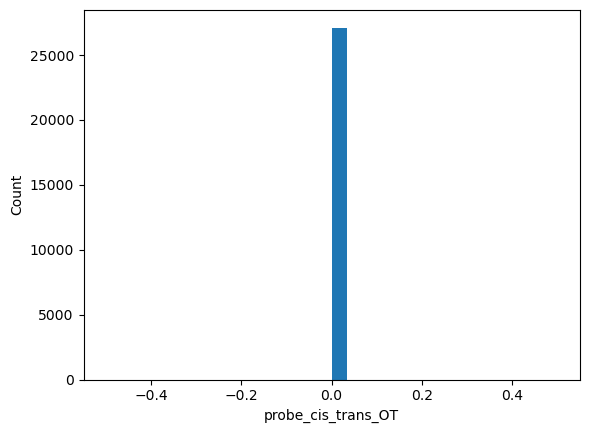

In [49]:
# Iterately remove the probes with high numbers of cis/trans-complementarity
# This filtering strategy is a compromise between speed and the number of probes to keep
while True:
    # Make a OTTable from the reverse-complement sequences of the probes.
    ottable_probes_rc = ot.get_OTTable_for_probe_dictionary(sel_pb_dict, 'target_readout_sequence', 15, rc=True)
    
    # The off-targets in this table indicates cis/trans-complementarity
    ot.calc_OTs(sel_pb_dict, ottable_probes_rc, 'target_readout_sequence', 'probe_cis_trans_OT', 15)
    max_ot = max(plot.get_values_from_probe_dict(sel_pb_dict, 'probe_cis_trans_OT'))
    if max_ot == 0:
        break
    
    # Remove probes that have any cis/trans-complementarity
    filters.filter_probe_dict_by_metric(sel_pb_dict, 'probe_cis_trans_OT', upper_bound=max_ot - 0.5)
    
plot.plot_hist(sel_pb_dict, 'probe_cis_trans_OT')

# Output

## default csv output

In [50]:
# Get the reverse-complementary sequences of the designed probes
p_d.get_rc_sequences(sel_pb_dict, 'target_readout_primer_sequence', 'target_readout_primer_sequence_rc')

# Get a data frame of all probes
df_all_probes = p_d.probe_dict_to_df(sel_pb_dict).sort_values(['probe_barcode', 'shift'])

# Make a column of probe names
probe_names = np.array(df_all_probes['gene_id']) + '_' + np.array(df_all_probes['transcript_id'])
probe_names = probe_names + '_shift:' + np.array(df_all_probes['shift']).astype(str)
probe_names = probe_names + '_GC:' + np.array(df_all_probes['target_GC']).astype('|S4').astype(str)
probe_names = probe_names + '_Tm:' + np.array(df_all_probes['target_Tm']).astype('|S4').astype(str)
probe_names = probe_names + '_specificity:' + np.array(df_all_probes['target_specificity']).astype('|S1').astype(str)
probe_names = probe_names + '_isospecificity:' + np.array(df_all_probes['target_isospecificity']).astype('|S4').astype(str)
probe_names = probe_names + '_' + np.array(df_all_probes['readout_names'])
df_all_probes['probe_names'] = probe_names

# Write the designed probes
print(probe_output_file)
df_all_probes.to_csv(probe_output_file, index=False)

c:\softwares\github\merfish_probe_design\MERFISH_probe_design\probe_design\probe_dict.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(probe_dict[gk][tk], ignore_index=True)


\\wi-bigdata.wi.mit.edu\solexa_weissman\puzheng\MERFISH_Probes\Brain_MS_immune\designed_probes.csv


# IDT version output

# Twistbio output

In [51]:
import re, time
from Bio.Seq import reverse_complement

In [52]:
twist_final_probes = pd.DataFrame(
    {
        "name": df_all_probes['probe_names'].values,
        "sequence": df_all_probes['target_readout_primer_sequence_rc'].values,
    }
)
twist_probe_filename = os.path.join(library_folder,
    f"{time.localtime().tm_year}_{time.localtime().tm_mon}_{time.localtime().tm_mday}_twist_merged_probes.xlsx")
print(f"saving twist probes to file: {twist_probe_filename}")
twist_final_probes.to_excel(twist_probe_filename, index=None)

saving twist probes to file: \\wi-bigdata.wi.mit.edu\solexa_weissman\puzheng\MERFISH_Probes\Brain_MS_immune\2023_7_5_twist_merged_probes.xlsx


## Manual checks:

In [61]:
twist_final_probes.loc[0,'name']

'Igkc_ENSMUST00000103410.3_shift:0_GC:53.3_Tm:56.5_specificity:1_isospecificity:0.01_Stv_28:Stv_28::Stv_28:Stv_28'

In [63]:
twist_final_probes.loc[0,'sequence'][20:40]

'GTCCTGTTCTTGTCGAGCGT'

In [59]:
twist_final_probes.loc[0,'sequence'][:20]

'CCCGCAATGGCTGACAACCG'

In [60]:
twist_final_probes.loc[0,'sequence'][-20:]

'CGGAAACCATGCGGCAATCC'

In [53]:
len(twist_final_probes)

27116

In [54]:
27116 / 96

282.4583333333333

In [55]:
len(sel_pb_dict)

294